#**`DCSI 592 Capstone II`**<br>
`Tumornators`<br>
  -Joseph Novak<br>
  -Shawn Oyer<br>
  -Patrick Obrien<br>
  -Thu Tran<br>

  `Summary`

  This notebook entails the training and testing of a logistic regression machine learning model built using lung texture features, to discern malignant lung CT images from non-malignant. Publicly available IQ-OTH/NCCD dataset was used for training and testing. DLCTLungDetectNet dataset was used for validation. The classifier performed on test data with a weighted per-class F1 score of .80 and validated with a weighted per-class F1 score of .81.

#**Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install pyfeats


In [ ]:
nbdir = "/content/drive/MyDrive/DSCI 592 Group/"
%cd /content/drive/MyDrive/DSCI\ 592\ Group/

/content/drive/.shortcut-targets-by-id/1BhYZe1XofBTGFx4baMx5R_lUbTcscQK4/DSCI 592 Group


Import libraries

In [ ]:
import os
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import filters
from skimage import data
from skimage import exposure
from skimage.segmentation import slic,clear_border
from skimage.color import label2rgb, rgb2gray
from skimage.feature import graycomatrix, graycoprops
from skimage.morphology import remove_small_objects,remove_small_holes, binary_closing,binary_dilation,disk, binary_erosion
from skimage.filters import roberts
from skimage.measure import label,regionprops

from scipy import ndimage as ndi
from scipy.ndimage import interpolation as inter
from scipy.stats import zscore

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
import joblib
from google.colab import files

import pyfeats
import glob
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import matplotlib.patches as mpatches

from sklearn.manifold import TSNE
from matplotlib import colors


**Custom functions**

This code constructs all functions for image processing, segmentation, metadata, etc.


In [ ]:
# Creates a new Data Frame with image filepaths, labels, and metadata info for all images within the specified directories
def get_image_metadata(image_path):
    with Image.open(image_path) as img:
        # Extract metadata
        info = {
            "jfif": img.info['jfif'],
            "jfif_version": img.info['jfif_version'],
            "jfif_unit": img.info['jfif_unit'],
            "jfif_density": img.info['jfif_density']
        }
        metadata = {
            "width": img.width,
            "height": img.height
            #"exif": img.getexif()
        }

    return info, metadata

def extract_metadata(benign_dir, Malignant_dir, Normal_dir):
    filepaths = []
    labels = []
    class_labels = ['Benign', 'Malignant', 'Normal']

    dir_lists = [benign_dir, Malignant_dir, Normal_dir]

    for i, dir_list in enumerate(dir_lists):
        for j in dir_list:
            flist = os.listdir(j)
            for f in flist:
                fpath = os.path.join(j, f)
                filepaths.append(fpath)
                labels.append(class_labels[i])

    Fseries = pd.Series(filepaths, name="filepaths")
    Lseries = pd.Series(labels, name="labels")
    Lung_data = pd.concat([Fseries, Lseries], axis=1)
    Lung_df = pd.DataFrame(Lung_data)
    pd.set_option('display.max_colwidth', None)
    jfif = []
    jfif_version = []
    dpi = []
    jfif_unit = []
    jfif_density = []
    width=[]
    height=[]
    #exif=[]

    for i in Lung_df["filepaths"]:
        info, metadata = get_image_metadata(i)
        jfif.append(info['jfif'])
        jfif_version.append(info['jfif_version'])
        jfif_unit.append(info['jfif_unit'])
        jfif_density.append(info['jfif_density'])
        width.append(metadata['width'])
        height.append(metadata['height'])
        #exif.append(metadata['exif'])

    jfif_series = pd.Series(jfif, name="info")
    jfif_version_series = pd.Series(jfif_version, name="jfif_version")
    jfif_unit_series = pd.Series(jfif_unit, name="jfif_unit")
    jfif_density_series = pd.Series(jfif_density, name="jfif_density")
    width_series = pd.Series(width, name="width")
    height_series = pd.Series(height, name="height")
    #exif_series = pd.Series(exif, name="exif")

    Lung_df = pd.concat([Lung_df, jfif_series, jfif_version_series, jfif_unit_series, jfif_density_series, width_series, height_series], axis=1)

    return Lung_df

# Function to compute statistics for a single image
def compute_image_stats(image):

    image_array = np.array(image)

    stats = {
        #'Image ID': os.path.basename(image),
        'Mean Pixel Value': np.nanmean(image_array),
        'Std Dev Pixel Value': np.nanstd(image_array),
        'Min Pixel Value': np.nanmin(image_array),
        'Max Pixel Value': np.nanmax(image_array),
        '25th Percentile': np.nanpercentile(image_array, 25),
        '50th Percentile (Median)': np.nanpercentile(image_array, 50),
        '75th Percentile': np.nanpercentile(image_array, 75)
    }

    return stats

# Get all image paths
def get_image_paths(dirs, file_extension):
    image_paths = []
    for dir in dirs:
        image_paths.extend(glob.glob(os.path.join(dir, f'*.{file_extension}')))

    return image_paths

def display_stats(df, label):
    # Display the statistics in table format
    print(f"{label} Image Statistics")
    stats_table = df.describe().T  # Transpose for better readability
    print(stats_table)

    # Convert the table to LaTeX
    latex_table = stats_table.to_latex()
    print("\nLaTeX Table:")
    print(latex_table)

    # Plot the statistics
    stats_table[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].plot(kind='bar', figsize=(10, 6))
    plt.title(f"{label} Image Statistics")
    plt.ylabel("Pixel Value")
    plt.xticks(rotation=45)
    plt.show()

def determine_score(arr, angle):
    data = inter.rotate(arr, angle, reshape=False, order=0)
    histogram = np.sum(data, axis=1, dtype=float)
    score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)

    return histogram, score

def correct_skew(image, delta=1, limit=5):
    #gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)
    best_angle = angles[scores.index(max(scores))]
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv.warpAffine(image, M, (w, h), flags=cv.INTER_CUBIC, \
            borderMode=cv.BORDER_REPLICATE)

    return best_angle, corrected

def bit_plane_slice(image):
    bit_planes = []
    for i in range(8):
        mask = 2 ** i
        bit_plane = np.bitwise_and(image, mask)
        bit_planes.append(bit_plane)

    return bit_planes

def reconstruct_image(bit_planes):
    reconstructed_image = np.zeros_like(bit_planes[0])
    for i in range(6):
        reconstructed_image = np.bitwise_or(reconstructed_image, bit_planes[-i])

    return reconstructed_image

def isolate_lung_area(image):
    label_image = label(image)
    regions = regionprops(label_image)
    image_height = image.shape[0]

    filtered_regions = [region for region in regions if region.area >= 600 and region.centroid[0] <= image_height * 0.75]
    regions = sorted(filtered_regions, key=lambda x: x.area, reverse=True)

    if len(regions) > 3:
      top_n_regions = sorted(regions, key=lambda x: x.centroid[0])
      top_n_highest_regions = top_n_regions[:-2]
    elif len(regions) > 2:
      top_n_regions = sorted(regions, key=lambda x: x.centroid[0])
      top_n_highest_regions = top_n_regions[:-1]
    else:
      top_n_highest_regions = regions

    mask = np.zeros_like(label_image, dtype=bool)
    for region in top_n_highest_regions:
        for coordinates in region.coords:
          mask[coordinates[0], coordinates[1]] = 1

    return mask

# Function to predict class label for validation data
def predict_image(img):
    img_flat = img.flatten().reshape(1, -1)  # Flatten and reshape image to match the input format expected by the model
    # Load the trained RandomForestClassifier model
    #best_model = joblib.load('best_RF_model.pkl')
    # Predict class label for the image
    pred_label = best_model.predict(img_flat)[0]  # Assuming you're only interested in the prediction for the first image in the batch
    # Return the predicted label
    return pred_label

def pipeline(image):
  camera =  cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  angle, corrected = correct_skew(camera)
  bit_planes = bit_plane_slice(corrected)
  bit_plane_reconstructed = reconstruct_image(bit_planes)
  gauss = cv.GaussianBlur(bit_plane_reconstructed, (5, 5), 5)
  thresh_val = filters.threshold_otsu(gauss)
  thresh = gauss<thresh_val

  cleared = clear_border(thresh)

  height = cleared.shape[0]
  bed_cutoff = int(height * 0.85)
  cleared[bed_cutoff:, :] = False

  cleared = isolate_lung_area(cleared)
  cleared = binary_dilation(cleared, footprint=disk(8))
  cleared = remove_small_objects(cleared,min_size=650)
  cleared = remove_small_holes(cleared,area_threshold=900)
  selem = disk(3, dtype=bool)
  cleared = binary_closing(cleared,disk(8))
  cleared = ndi.binary_fill_holes(cleared)
  cleared = binary_erosion(cleared, selem)

  cleared = binary_closing(cleared,disk(12))

  result1 = gauss.copy()
  result1[cleared == 0] = 0
  #transform 0s to Nans
  result1 = np.where(result1 == 0, np.nan, result1)
  result1[cleared != 0] = gauss[cleared != 0]

  #zscore the dataset, ignoring mask regions
  result1[cleared != 0] = (result1[cleared != 0]-np.mean(result1[cleared != 0]))/np.std(result1[cleared != 0])

  return result1


#**Scikit Segmentation**#

##**Test Set**


###**DATA / IMAGE PREPROCESSING**

In [ ]:
benign_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Bengin cases']
Malignant_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Malignant cases']
Normal_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Normal cases']

In [ ]:
#This code chunk takes ~5 mins
Lung_df = extract_metadata(benign_dir, Malignant_dir, Normal_dir)
Lung_df.head()

,filepaths,labels,info,jfif_version,jfif_unit,jfif_density,width,height
0,./data/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (96).jpg,Benign,257,"(1, 1)",1,"(120, 120)",512,512
1,./data/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (97).jpg,Benign,257,"(1, 1)",1,"(120, 120)",512,512
2,./data/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (87).jpg,Benign,257,"(1, 1)",1,"(120, 120)",512,512
3,./data/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (79).jpg,Benign,257,"(1, 1)",1,"(120, 120)",512,512
4,./data/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (99).jpg,Benign,257,"(1, 1)",1,"(120, 120)",512,512


In [ ]:
#3. Check for duplicates and NULL Values
# Drop duplicates
Lung_df = Lung_df.drop_duplicates()
print(Lung_df.shape)

# Check for NULL Values
print("\n Check for any null values in dataset:")
Lung_df = Lung_df.replace(r'^\s*$', np.nan, regex=True)
print(pd.isnull(Lung_df).sum())
print("\n Removing null values in dataset:")
print(pd.isnull(Lung_df).sum())

(1102, 8)

 Check for any null values in dataset:
filepaths       0
labels          0
info            0
jfif_version    0
jfif_unit       0
jfif_density    0
width           0
height          0
dtype: int64

 Removing null values in dataset:
filepaths       0
labels          0
info            0
jfif_version    0
jfif_unit       0
jfif_density    0
width           0
height          0
dtype: int64


In [ ]:
# Print Value Counts to identify outliers or missing values
print(Lung_df["width"].value_counts())
print(Lung_df["height"].value_counts())
print(Lung_df["info"].value_counts())

width
512    1100
511       1
506       1
Name: count, dtype: int64
height
512    1100
404       1
331       1
Name: count, dtype: int64
info
257    1102
Name: count, dtype: int64


In [ ]:
Lung_df_filtered = Lung_df[Lung_df["width"]==512]
Lung_df_filtered = Lung_df_filtered[Lung_df_filtered["height"]==512]
print(f"# scans passed QC: {Lung_df_filtered.shape[0]}")

# scans passed QC: 1100


Inclusion criteria: height x width = 512x512

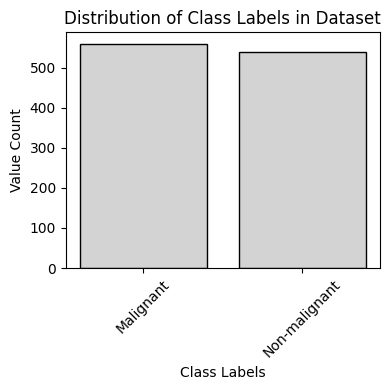

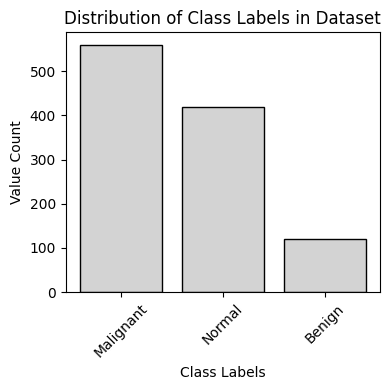

In [ ]:
mapping={"Normal":"Non-malignant","Benign":"Non-malignant","Malignant":"Malignant"}
Lung_df_filtered["labels_2"]= Lung_df_filtered["labels"].map(mapping)

label_counts = Lung_df_filtered['labels_2'].value_counts()


plt.figure(figsize=(4, 4))
plt.bar(label_counts.index, label_counts.values, color='#D3D3D3',edgecolor="black")
plt.xlabel('Class Labels')
plt.ylabel('Value Count')
plt.title('Distribution of Class Labels in Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

label_counts = Lung_df_filtered['labels'].value_counts()

plt.figure(figsize=(4, 4))
plt.bar(label_counts.index, label_counts.values, color='#D3D3D3',edgecolor="black")
plt.xlabel('Class Labels')
plt.ylabel('Value Count')
plt.title('Distribution of Class Labels in Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#plt.savefig('label_barplot.jpg')
#files.download('label_barplot.jpg')

<Figure size 640x480 with 0 Axes>

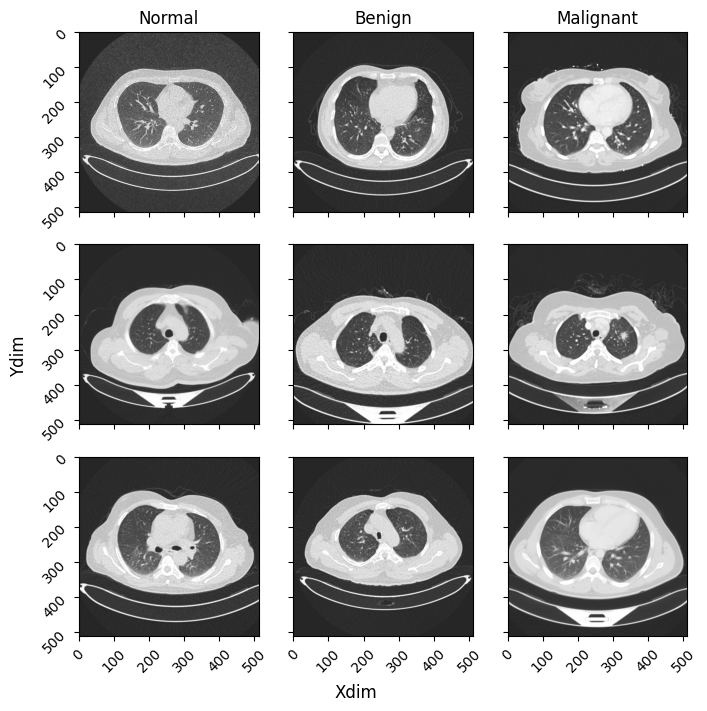

In [ ]:
#View three of each image type
n1 = cv.imread('./data/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (319).jpg')
n2 = cv.imread('./data/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (123).jpg')
n3 = cv.imread('./data/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (243).jpg')
b1 = cv.imread('./data/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (11).jpg')
b2 = cv.imread('./data/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (119).jpg')
b3 = cv.imread('./data/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (70).jpg')
m1 = cv.imread('./data/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (118).jpg')
m2 = cv.imread('./data/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (129).jpg')
m3 = cv.imread('./data/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (340).jpg')

plt.figure()
fig, axs = plt.subplots(3, 3, figsize=(7, 7), layout='constrained',
                        sharex=True, sharey=True)
plt.xticks(rotation=45)

axs[0,0].imshow(n1)
axs[0,0].set_title('Normal')
axs[0,1].imshow(b1)
axs[0,1].set_title('Benign')
axs[0,2].imshow(m1)
axs[0,2].set_title('Malignant')
axs[1,0].imshow(n2)
axs[1,1].imshow(b2)
axs[1,2].imshow(m2)
axs[2,0].imshow(n3)
axs[2,1].imshow(b3)
axs[2,2].imshow(m3)

fig.supxlabel('Xdim')
fig.supylabel('Ydim')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks([0,100,200,300,400,500],rotation=45)
    plt.yticks(rotation=45)

Process all images through the segmentation / mask pipeline

In [ ]:
%%capture
#process images and add to image_array
#this chunk take ~9min
image_array=[]
for i in Lung_df_filtered["filepaths"]:
  image_array.append(pipeline(cv.imread(i)))

Compute pixel statistics, ignoring 0's. Effectively, this  values measures only pixels from the segmented lung tissue

In [ ]:
image_stats = [compute_image_stats(image_path) for image_path in image_array]
image_stats_df = pd.DataFrame(image_stats)

left-join statistics to the metadata table

In [ ]:
Lung_df_filtered_2 = pd.concat([Lung_df_filtered.reset_index(drop=True), image_stats_df.reset_index(drop=True)],axis=1)
print(len(Lung_df_filtered_2))
Lung_df_filtered_2.tail()

1100


,filepaths,labels,info,jfif_version,jfif_unit,jfif_density,width,height,labels_2,Mean Pixel Value,Std Dev Pixel Value,Min Pixel Value,Max Pixel Value,25th Percentile,50th Percentile (Median),75th Percentile
1095,./data/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (100) (1).jpg,Normal,257,"(1, 1)",1,"(120, 120)",512,512,Non-malignant,-1.268452e-16,1.0,-1.224175,3.544649,-0.624665,-0.433912,0.247348
1096,./data/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (100).jpg,Normal,257,"(1, 1)",1,"(120, 120)",512,512,Non-malignant,-1.268452e-16,1.0,-1.224175,3.544649,-0.624665,-0.433912,0.247348
1097,./data/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (105).jpg,Normal,257,"(1, 1)",1,"(120, 120)",512,512,Non-malignant,-1.305828e-16,1.0,-1.217816,3.466587,-0.870824,-0.275979,0.343651
1098,./data/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (109).jpg,Normal,257,"(1, 1)",1,"(120, 120)",512,512,Non-malignant,1.605112e-16,1.0,-1.050658,3.439165,-0.647380,-0.432299,0.132290
1099,./data/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (106).jpg,Normal,257,"(1, 1)",1,"(120, 120)",512,512,Non-malignant,-1.352687e-16,1.0,-1.232376,3.470802,-0.836319,-0.316494,0.401359


Plot per-class mean pixel intensity values

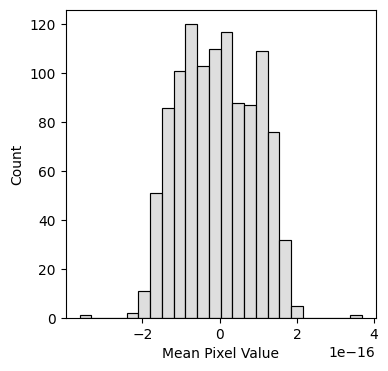

In [ ]:
plt.figure(figsize=(4, 4))
sns.histplot(x=Lung_df_filtered_2["Mean Pixel Value"],color="#D3D3D3",edgecolor="black")
plt.ticklabel_format( axis='x')


In [ ]:
mapping={"Normal":"Non-malignant","Benign":"Non-malignant","Malignant":"Malignant"}
Lung_df_filtered_2["labels_2"]= Lung_df_filtered_2["labels"].map(mapping)

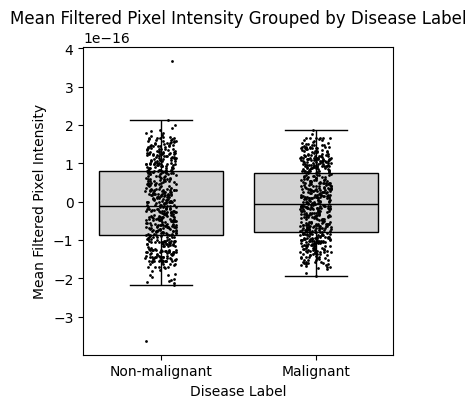

In [ ]:
plt.figure(figsize=(4, 4))
sns.boxplot(x=Lung_df_filtered_2["labels_2"],y=Lung_df_filtered_2['Mean Pixel Value'],showfliers=False,color="#D3D3D3",linecolor="black")
sns.stripplot(x=Lung_df_filtered_2["labels_2"],y=Lung_df_filtered_2['Mean Pixel Value'],color='black', size=2)
plt.title('Mean Filtered Pixel Intensity Grouped by Disease Label')
plt.ylabel('Mean Filtered Pixel Intensity')
plt.xlabel('Disease Label')
plt.show()


Compute the texture features to be used for machine learning

###**Extract Features**

In [ ]:
%%capture
#compute feature arrays for GLCM texture analysis
data=[]
for img in image_array:
    glcm = pyfeats.glcm_features(img,ignore_zeros=True)[0]
    data.append(glcm)

labels = ["GLCM_ASM", "GLCM_Contrast", "GLCM_Correlation","GLCM_SumOfSquaresVariance", "GLCM_InverseDifferenceMoment","GLCM_SumAverage", "GLCM_SumVariance", "GLCM_SumEntropy","GLCM_Entropy", "GLCM_DifferenceVariance","GLCM_DifferenceEntropy", "GLCM_Information1","GLCM_Information2", "GLCM_MaximalCorrelationCoefficient"]
temp = pd.DataFrame(data,columns=labels)
temp.head()

###**EDA**

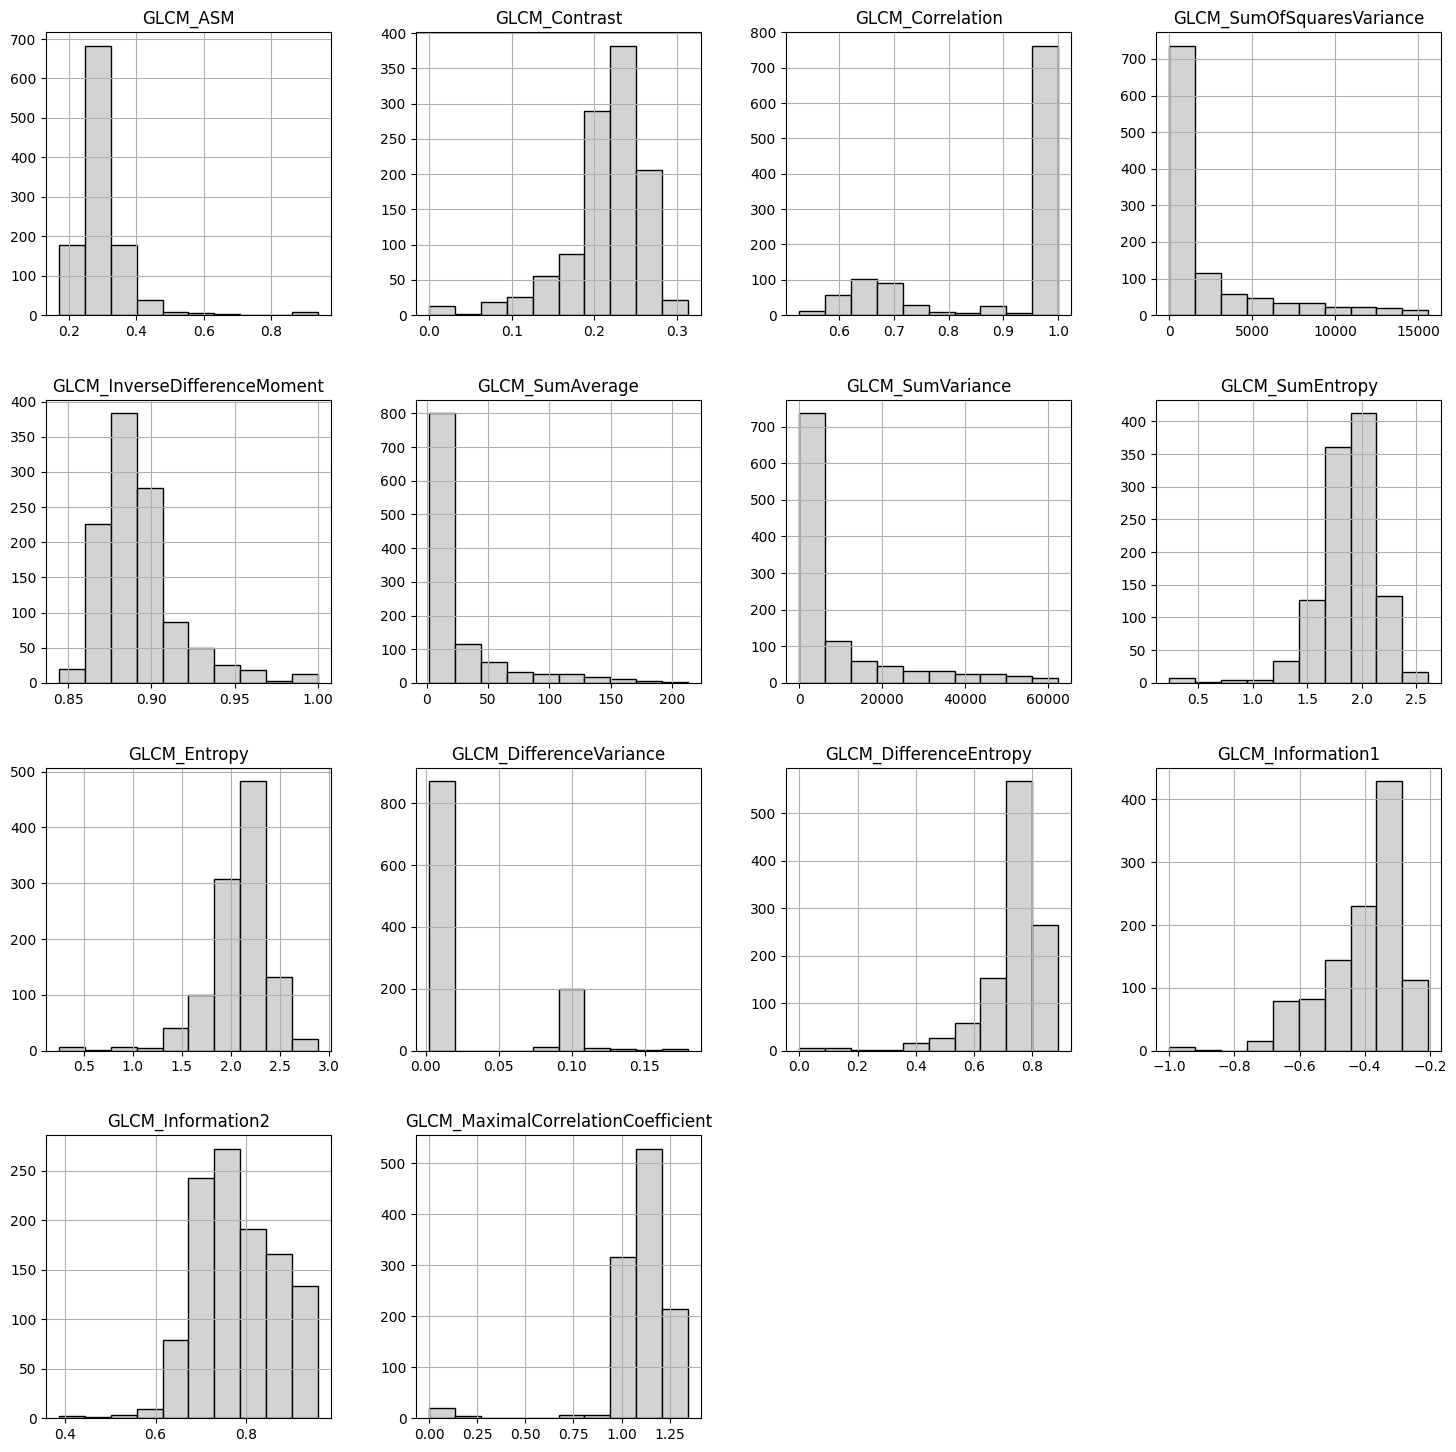

In [ ]:
master_table.drop(['filepaths', 'labels', 'info', 'jfif_version', 'jfif_unit',"Mean Pixel Value","Std Dev Pixel Value","Min Pixel Value","Max Pixel Value",
       'jfif_density','width', 'height',"25th Percentile","50th Percentile (Median)","75th Percentile"],axis=1).hist(bins=10, figsize=(18,18),edgecolor="black",color="#D3D3D3")
plt.show()

In [ ]:
master_table.drop(['filepaths', 'labels', 'info', 'jfif_version', 'jfif_unit',"Mean Pixel Value","Std Dev Pixel Value","Min Pixel Value","Max Pixel Value",
       'jfif_density','width', 'height',"25th Percentile","50th Percentile (Median)","75th Percentile"],axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
GLCM_ASM,1100.0,0.298401,0.076388,0.171366,0.261847,0.287581,0.318378,0.937620
GLCM_Contrast,1100.0,0.215507,0.046995,0.000000,0.198942,0.223798,0.247000,0.313437
GLCM_Correlation,1100.0,0.903077,0.152256,0.527413,0.735691,0.999715,0.999961,1.000000
GLCM_SumOfSquaresVariance,1100.0,2175.375223,3513.600325,0.053878,3.122760,389.209753,2816.053115,15592.076551
GLCM_InverseDifferenceMoment,1100.0,0.892422,0.023369,0.844598,0.876778,0.888217,0.900550,1.000000
GLCM_SumAverage,1100.0,23.920881,36.953521,2.072013,3.437720,6.349602,26.333954,212.929421
GLCM_SumVariance,1100.0,8701.285384,14054.419567,0.184988,12.268060,1556.685092,11264.023364,62368.162420
GLCM_SumEntropy,1100.0,1.874217,0.273049,0.234650,1.748603,1.900980,2.032368,2.608907
GLCM_Entropy,1100.0,2.090601,0.305576,0.249392,1.963959,2.132219,2.264556,2.884432
GLCM_DifferenceVariance,1100.0,0.023137,0.040528,0.002255,0.002493,0.002623,0.003102,0.179717


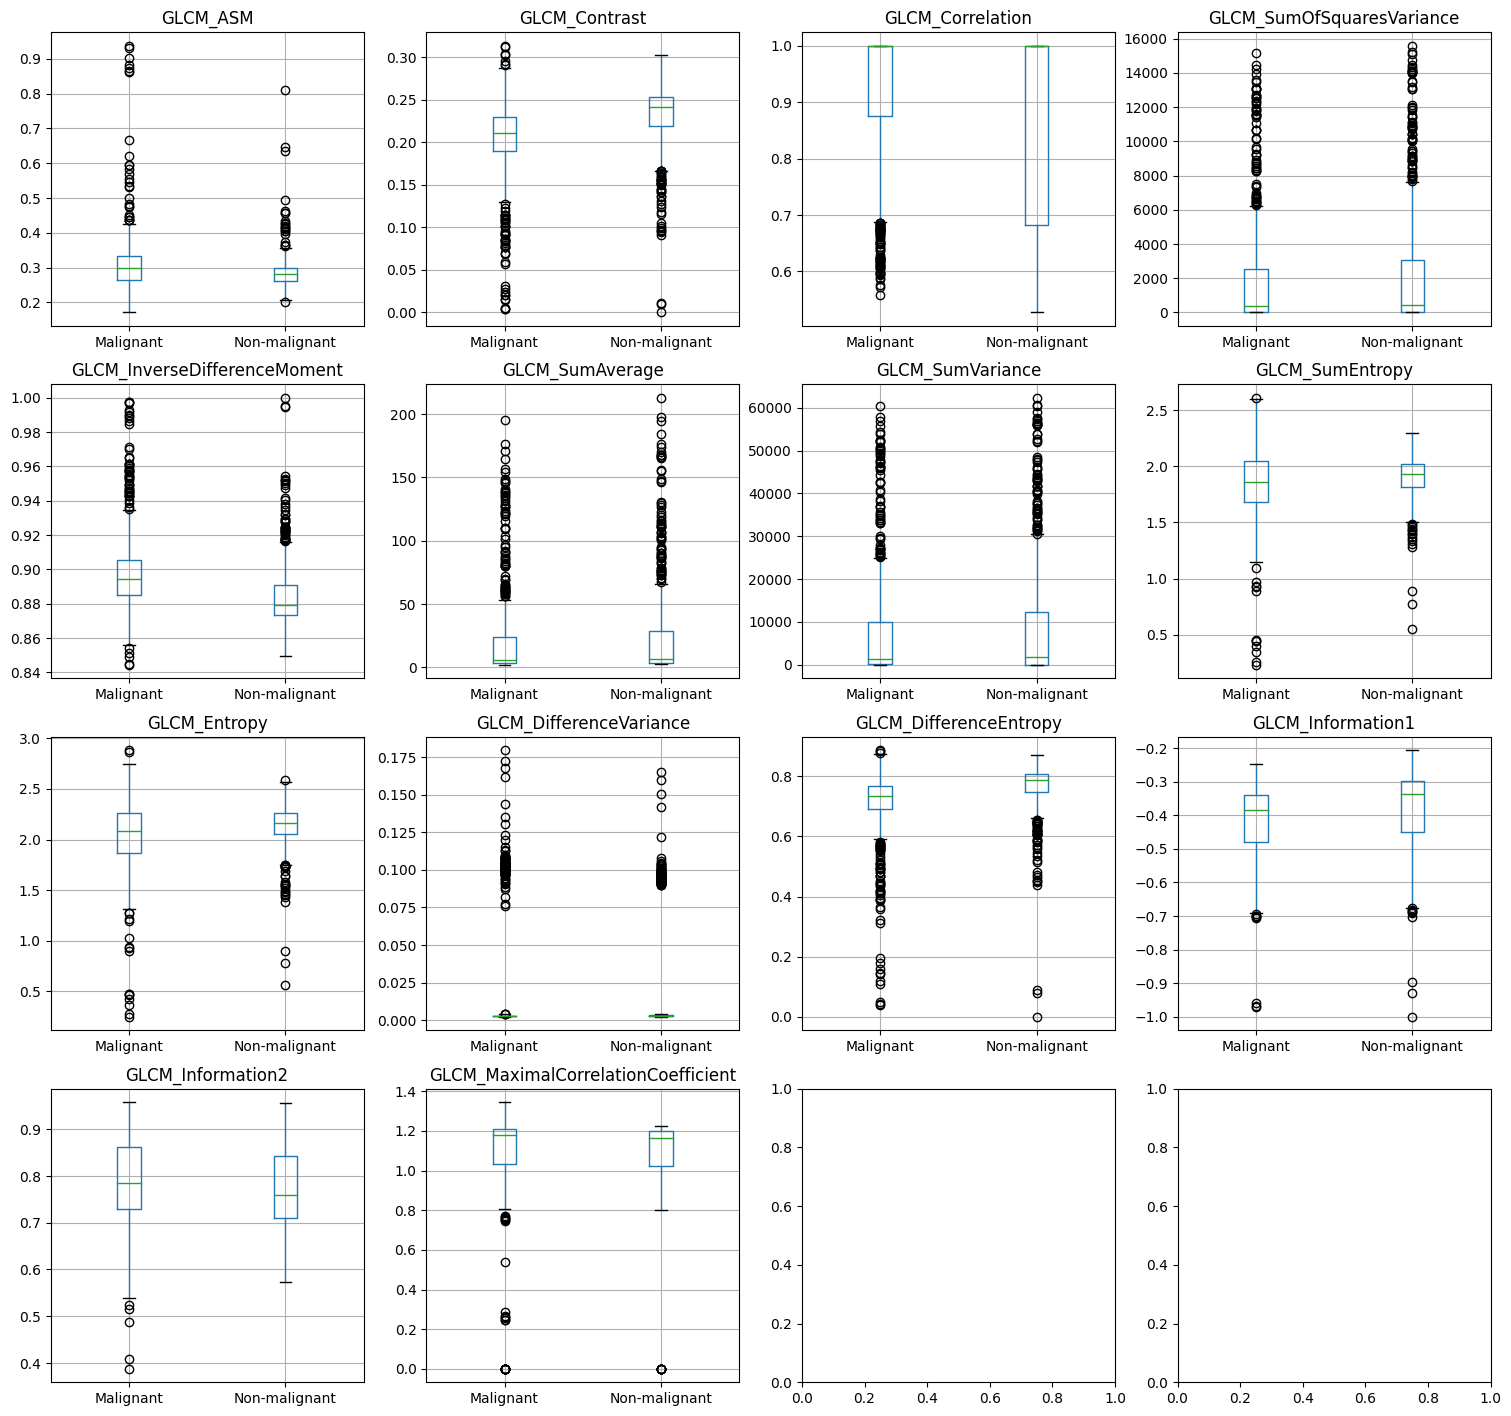

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(18, 18))
master_table.boxplot('GLCM_ASM','labels_2', ax=ax[0, 0])
master_table.boxplot('GLCM_Contrast','labels_2', ax=ax[0, 1])
master_table.boxplot('GLCM_Correlation','labels_2', ax=ax[0,2])
master_table.boxplot('GLCM_SumOfSquaresVariance','labels_2', ax=ax[0,3])
master_table.boxplot('GLCM_InverseDifferenceMoment','labels_2', ax=ax[1,0])
master_table.boxplot('GLCM_SumAverage','labels_2', ax=ax[1, 1])
master_table.boxplot('GLCM_SumVariance','labels_2', ax=ax[1, 2])
master_table.boxplot('GLCM_SumEntropy','labels_2', ax=ax[1,3])
master_table.boxplot('GLCM_Entropy','labels_2', ax=ax[2,0])
master_table.boxplot('GLCM_DifferenceVariance','labels_2', ax=ax[2,1])
master_table.boxplot('GLCM_DifferenceEntropy','labels_2', ax=ax[2, 2])
master_table.boxplot('GLCM_Information1','labels_2', ax=ax[2, 3])
master_table.boxplot('GLCM_Information2','labels_2', ax=ax[3,0])
master_table.boxplot('GLCM_MaximalCorrelationCoefficient','labels_2', ax=ax[3,1])

for ax in fig.axes:
  ax.set(xlabel=None)
fig.suptitle('')
plt.show()

Correlate the image texture features are any redundant / complementory?

<Axes: >

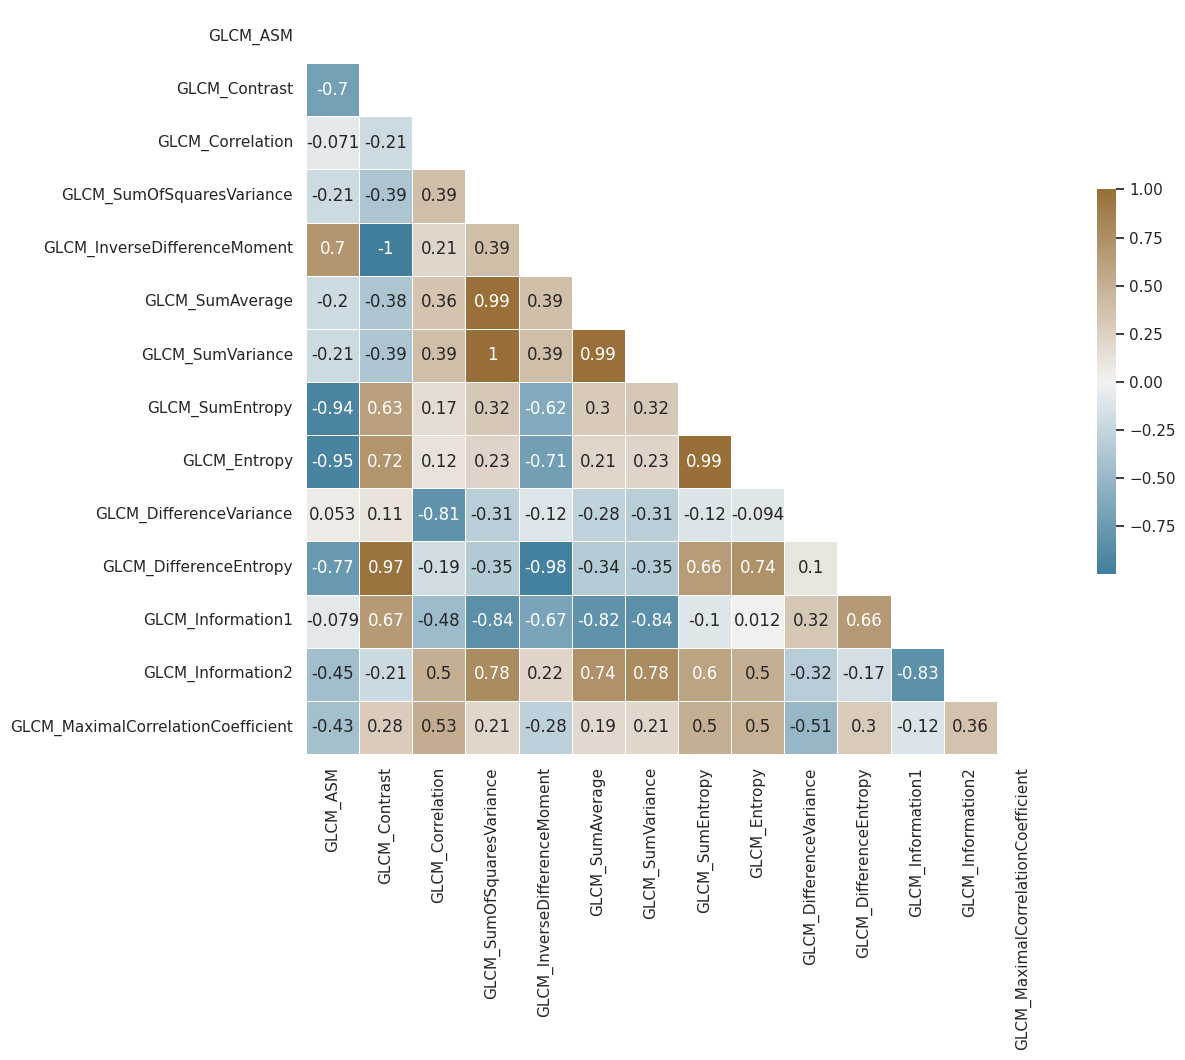

In [ ]:
master_table_new_drop = master_table.drop(columns=["Mean Pixel Value","Std Dev Pixel Value","25th Percentile","50th Percentile (Median)","75th Percentile",'filepaths', 'labels',"labels_2", 'info', 'jfif_version',
                                                               'jfif_unit', 'jfif_density', 'width', 'height','Max Pixel Value', 'Min Pixel Value'])
sns.set(style="white")
corr = master_table_new_drop.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 50, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

###**PCA**

##**Validation Set**

###**DATA / IMAGE PREPROCESSING**

In [ ]:
#Set Directories
normal_dir = ['./data/DLCTLungDetectNet/Unrefined Data/normal']
Malignant_dir = ['./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma']
Malignant_dir2 = ['./data/DLCTLungDetectNet/Unrefined Data/squamous.cell.carcinoma']
Malignant_dir3 = ['./data/DLCTLungDetectNet/Unrefined Data/adenocarcinoma']

In [ ]:
#Extract metadata from validation dataset
dir_lists = [Malignant_dir,Malignant_dir2,Malignant_dir3, normal_dir]
filepaths=[]
labels=[]
class_labels = ["Malignant","Malignant",'Malignant','Normal']
for i, dir_list in enumerate(dir_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

height=[]
width=[]
for i in filepaths:
        tmp = Image.open(i)
        width.append(tmp.width)
        height.append(tmp.height)

Lung_df_validation = pd.DataFrame({'filepath': filepaths, 'label': labels,"height":height,"width":width})
Lung_df_validation.head()

,filepath,label,height,width
0,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma/large.cell.carcinoma160.png,Malignant,311,454
1,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma/large.cell.carcinoma131.png,Malignant,291,391
2,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma/large.cell.carcinoma53.png,Malignant,298,358
3,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma/large.cell.carcinoma24.png,Malignant,277,361
4,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma/large.cell.carcinoma5.png,Malignant,267,423


Process the validation dataset

In [ ]:
%%capture
#process images and add to image_array
#this chunk take ~7min
image_array_validation=[]
for i in Lung_df_validation["filepath"]:
  image_array_validation.append(pipeline(cv.imread(i)))

After processing, some of the images were empty, find those images with no variance and label them as Empty

In [ ]:
empty=[]
for i in image_array_validation:
  if np.nansum(i)==  0:
    empty.append("Empty")
  else:
    empty.append("Not Empty")

Lung_df_validation["Empty"] = empty
pd.value_counts(Lung_df_validation["Empty"])

<ipython-input-29-7b49399f2c10>:9: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(Lung_df_validation["Empty"])


,count
Empty,
Not Empty,969
Empty,31


In [ ]:
image_array_clean = [img for img, is_empty in zip(image_array_validation, Lung_df_validation["Empty"]=="Not Empty") if is_empty]
Lung_df_filtered_validation = Lung_df_validation[Lung_df_validation["Empty"]=="Not Empty"]

In [ ]:
image_stats_validation = [compute_image_stats(image_path) for image_path in image_array_clean]
image_stats_df_validation = pd.DataFrame(image_stats_validation)

In [ ]:
Lung_df_filtered_2_validation = pd.concat([Lung_df_filtered_validation.reset_index(drop=True), image_stats_df_validation.reset_index(drop=True)],axis=1)
print(len(Lung_df_filtered_2_validation))
Lung_df_filtered_2_validation.tail()

969


,filepath,label,height,width,Empty,Mean Pixel Value,Std Dev Pixel Value,Min Pixel Value,Max Pixel Value,25th Percentile,50th Percentile (Median),75th Percentile
964,./data/DLCTLungDetectNet/Unrefined Data/normal/normal80.png,Normal,577,800,Not Empty,-4.083850e-17,1.0,-1.168930,4.335682,-0.503050,-0.369874,-0.081325
965,./data/DLCTLungDetectNet/Unrefined Data/normal/normal82.png,Normal,577,800,Not Empty,-4.083850e-17,1.0,-1.168930,4.335682,-0.503050,-0.369874,-0.081325
966,./data/DLCTLungDetectNet/Unrefined Data/normal/normal90.png,Normal,251,371,Not Empty,-2.793190e-17,1.0,-0.984107,2.974946,-0.611281,-0.540267,0.134370
967,./data/DLCTLungDetectNet/Unrefined Data/normal/normal84.png,Normal,577,800,Not Empty,-4.083850e-17,1.0,-1.168930,4.335682,-0.503050,-0.369874,-0.081325
968,./data/DLCTLungDetectNet/Unrefined Data/normal/normal96.png,Normal,251,371,Not Empty,-2.793190e-17,1.0,-0.984107,2.974946,-0.611281,-0.540267,0.134370


###**Extract Features**

In [ ]:
%%capture
#compute feature arrays for GLCM texture analysis
data2=[]
for img in image_array_clean:
    glcm = pyfeats.glcm_features(img,ignore_zeros=True)[0]
    data2.append(glcm)

labels = ["GLCM_ASM", "GLCM_Contrast", "GLCM_Correlation","GLCM_SumOfSquaresVariance", "GLCM_InverseDifferenceMoment","GLCM_SumAverage", "GLCM_SumVariance", "GLCM_SumEntropy","GLCM_Entropy", "GLCM_DifferenceVariance","GLCM_DifferenceEntropy", "GLCM_Information1","GLCM_Information2", "GLCM_MaximalCorrelationCoefficient"]
temp2 = pd.DataFrame(data2,columns=labels)
temp2.head()

In [ ]:
#Concatenate feature attributes with metadata table
master_table_validation = pd.concat([Lung_df_filtered_2_validation.reset_index(drop=True), temp2.reset_index(drop=True)], axis=1)
print(len(master_table_validation))
master_table_validation.tail()
#Lung_df.to_csv("validation_normalized_metadata_w_features_2024_08_20.csv")
#from google.colab import files
#files.download("validation_normalized_metadata_w_features_2024_08_20.csv")

969


,filepath,label,height,width,Empty,Mean Pixel Value,Std Dev Pixel Value,Min Pixel Value,Max Pixel Value,25th Percentile,...,GLCM_InverseDifferenceMoment,GLCM_SumAverage,GLCM_SumVariance,GLCM_SumEntropy,GLCM_Entropy,GLCM_DifferenceVariance,GLCM_DifferenceEntropy,GLCM_Information1,GLCM_Information2,GLCM_MaximalCorrelationCoefficient
964,./data/DLCTLungDetectNet/Unrefined Data/normal/normal80.png,Normal,577,800,Not Empty,-4.083850e-17,1.0,-1.168930,4.335682,-0.503050,...,0.830515,11.612276,3600.046071,2.723018,3.096045,0.002155,0.951031,-0.417279,0.893481,1.292895
965,./data/DLCTLungDetectNet/Unrefined Data/normal/normal82.png,Normal,577,800,Not Empty,-4.083850e-17,1.0,-1.168930,4.335682,-0.503050,...,0.830515,11.612276,3600.046071,2.723018,3.096045,0.002155,0.951031,-0.417279,0.893481,1.292895
966,./data/DLCTLungDetectNet/Unrefined Data/normal/normal90.png,Normal,251,371,Not Empty,-2.793190e-17,1.0,-0.984107,2.974946,-0.611281,...,0.948795,2.542866,0.688611,1.195897,1.298307,0.161123,0.474439,-0.460904,0.733128,0.000000
967,./data/DLCTLungDetectNet/Unrefined Data/normal/normal84.png,Normal,577,800,Not Empty,-4.083850e-17,1.0,-1.168930,4.335682,-0.503050,...,0.830515,11.612276,3600.046071,2.723018,3.096045,0.002155,0.951031,-0.417279,0.893481,1.292895
968,./data/DLCTLungDetectNet/Unrefined Data/normal/normal96.png,Normal,251,371,Not Empty,-2.793190e-17,1.0,-0.984107,2.974946,-0.611281,...,0.948795,2.542866,0.688611,1.195897,1.298307,0.161123,0.474439,-0.460904,0.733128,0.000000


In [ ]:
%%capture
val = master_table_validation
val["label"][val["label"]=="Malignant"]="Malignant"
val["label"][val["label"]=="Normal"]="Non-malignant"

In [ ]:
val.tail()

,filepath,label,height,width,Empty,Mean Pixel Value,Std Dev Pixel Value,Min Pixel Value,Max Pixel Value,25th Percentile,...,GLCM_InverseDifferenceMoment,GLCM_SumAverage,GLCM_SumVariance,GLCM_SumEntropy,GLCM_Entropy,GLCM_DifferenceVariance,GLCM_DifferenceEntropy,GLCM_Information1,GLCM_Information2,GLCM_MaximalCorrelationCoefficient
964,./data/DLCTLungDetectNet/Unrefined Data/normal/normal80.png,Non-malignant,577,800,Not Empty,-4.083850e-17,1.0,-1.168930,4.335682,-0.503050,...,0.830515,11.612276,3600.046071,2.723018,3.096045,0.002155,0.951031,-0.417279,0.893481,1.292895
965,./data/DLCTLungDetectNet/Unrefined Data/normal/normal82.png,Non-malignant,577,800,Not Empty,-4.083850e-17,1.0,-1.168930,4.335682,-0.503050,...,0.830515,11.612276,3600.046071,2.723018,3.096045,0.002155,0.951031,-0.417279,0.893481,1.292895
966,./data/DLCTLungDetectNet/Unrefined Data/normal/normal90.png,Non-malignant,251,371,Not Empty,-2.793190e-17,1.0,-0.984107,2.974946,-0.611281,...,0.948795,2.542866,0.688611,1.195897,1.298307,0.161123,0.474439,-0.460904,0.733128,0.000000
967,./data/DLCTLungDetectNet/Unrefined Data/normal/normal84.png,Non-malignant,577,800,Not Empty,-4.083850e-17,1.0,-1.168930,4.335682,-0.503050,...,0.830515,11.612276,3600.046071,2.723018,3.096045,0.002155,0.951031,-0.417279,0.893481,1.292895
968,./data/DLCTLungDetectNet/Unrefined Data/normal/normal96.png,Non-malignant,251,371,Not Empty,-2.793190e-17,1.0,-0.984107,2.974946,-0.611281,...,0.948795,2.542866,0.688611,1.195897,1.298307,0.161123,0.474439,-0.460904,0.733128,0.000000


###**EDA**

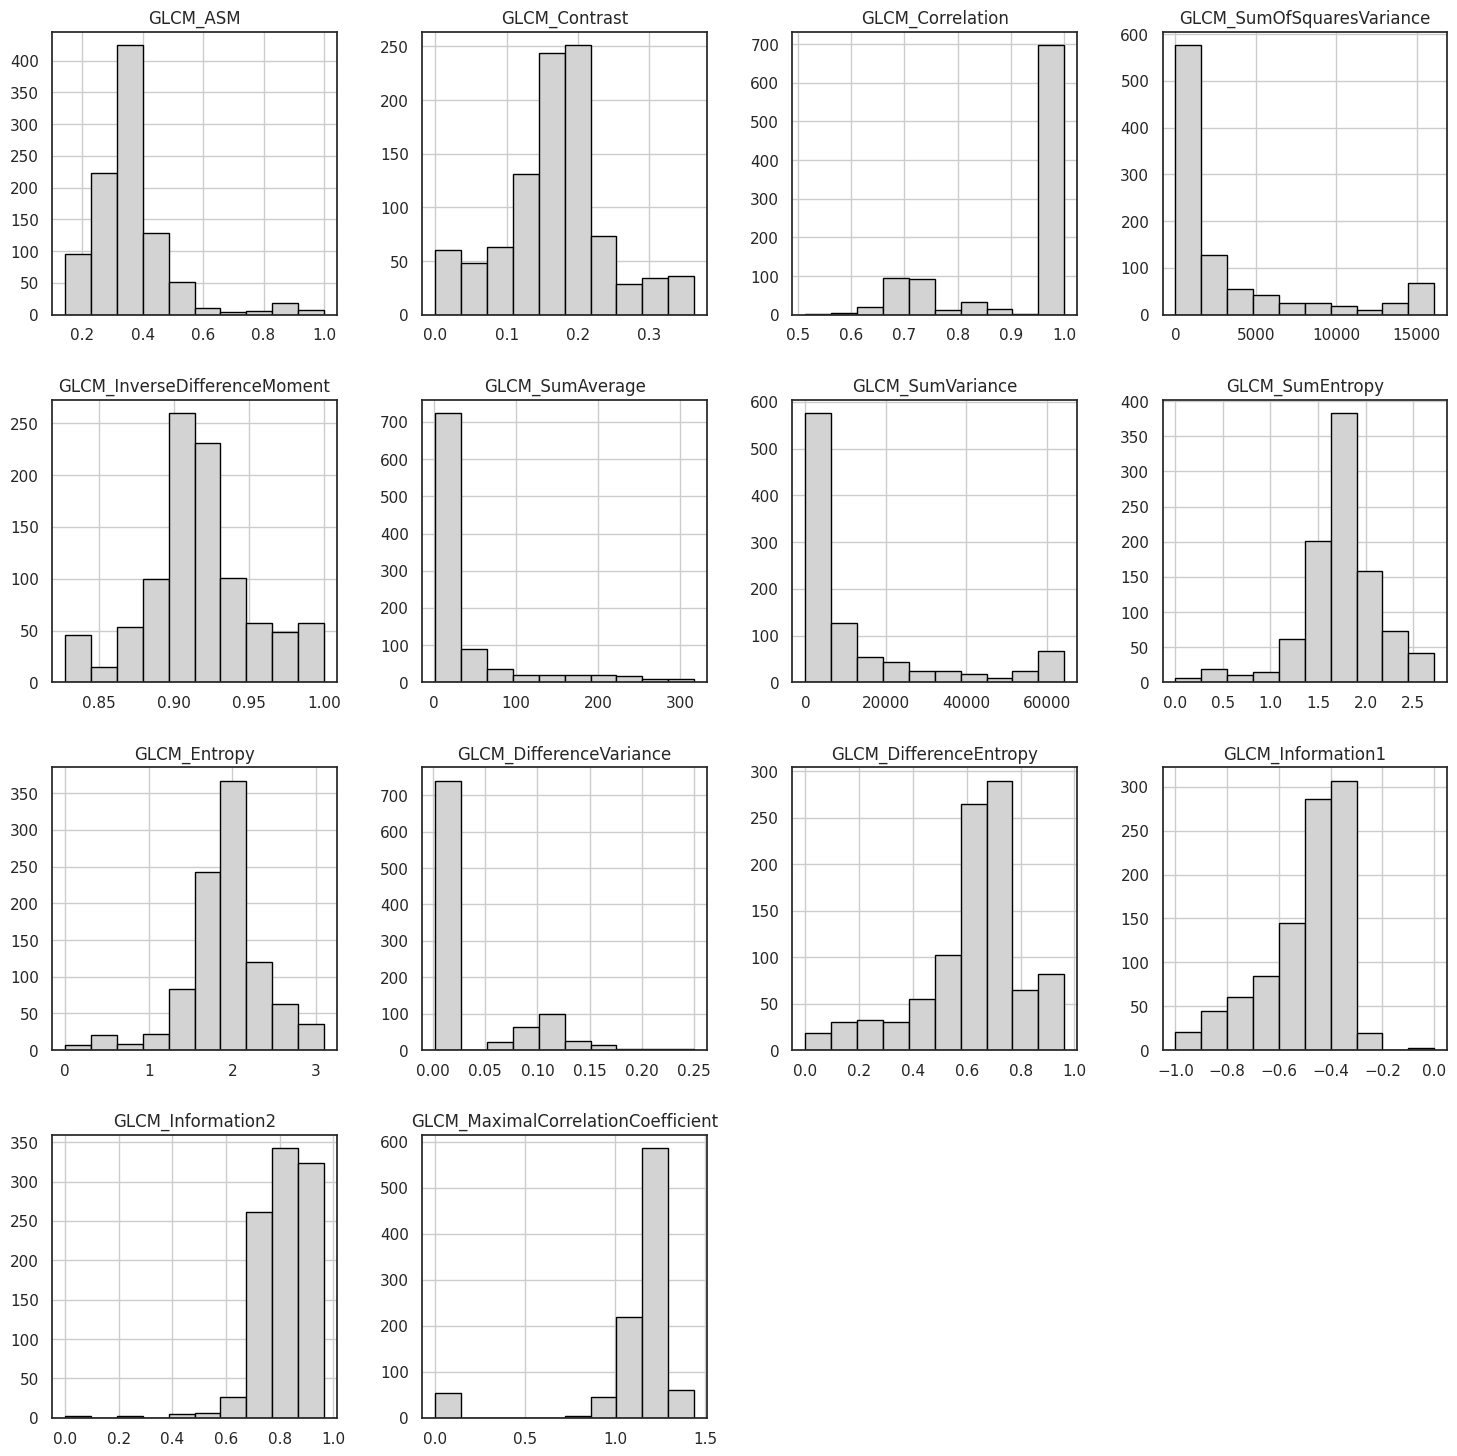

In [ ]:
val.drop(['filepath', 'label', 'height', 'width', 'Empty',"Mean Pixel Value","Std Dev Pixel Value","Min Pixel Value","Max Pixel Value",
       "25th Percentile","50th Percentile (Median)","75th Percentile"],axis=1).hist(bins=10, figsize=(18,18),edgecolor="black",color="#D3D3D3")
plt.show()

In [ ]:
val.drop(['filepath', 'label', 'height', 'width', 'Empty',"Mean Pixel Value","Std Dev Pixel Value","Min Pixel Value","Max Pixel Value",
       "25th Percentile","50th Percentile (Median)","75th Percentile"],axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
GLCM_ASM,969.0,0.361430,0.130689,0.143516,0.300334,0.340003,0.393848,1.000000
GLCM_Contrast,969.0,0.169652,0.074555,0.000000,0.132032,0.172162,0.202118,0.362788
GLCM_Correlation,969.0,0.924524,0.126453,0.514282,0.846025,0.999876,0.999983,1.000000
GLCM_SumOfSquaresVariance,969.0,3070.051923,4663.238397,0.000000,0.962269,780.643746,3720.546104,16096.273866
GLCM_InverseDifferenceMoment,969.0,0.916509,0.035561,0.827465,0.899363,0.914375,0.934274,1.000000
GLCM_SumAverage,969.0,37.175708,62.315758,2.000000,3.591143,9.485262,33.985309,316.980566
GLCM_SumVariance,969.0,12280.038042,18652.994591,0.000000,3.568156,3122.403614,14882.031460,64385.095113
GLCM_SumEntropy,969.0,1.737882,0.412265,0.000000,1.560513,1.745792,1.936183,2.723018
GLCM_Entropy,969.0,1.911225,0.479978,0.000000,1.707749,1.926158,2.134597,3.096990
GLCM_DifferenceVariance,969.0,0.028454,0.048205,0.002138,0.002730,0.002944,0.003820,0.250000


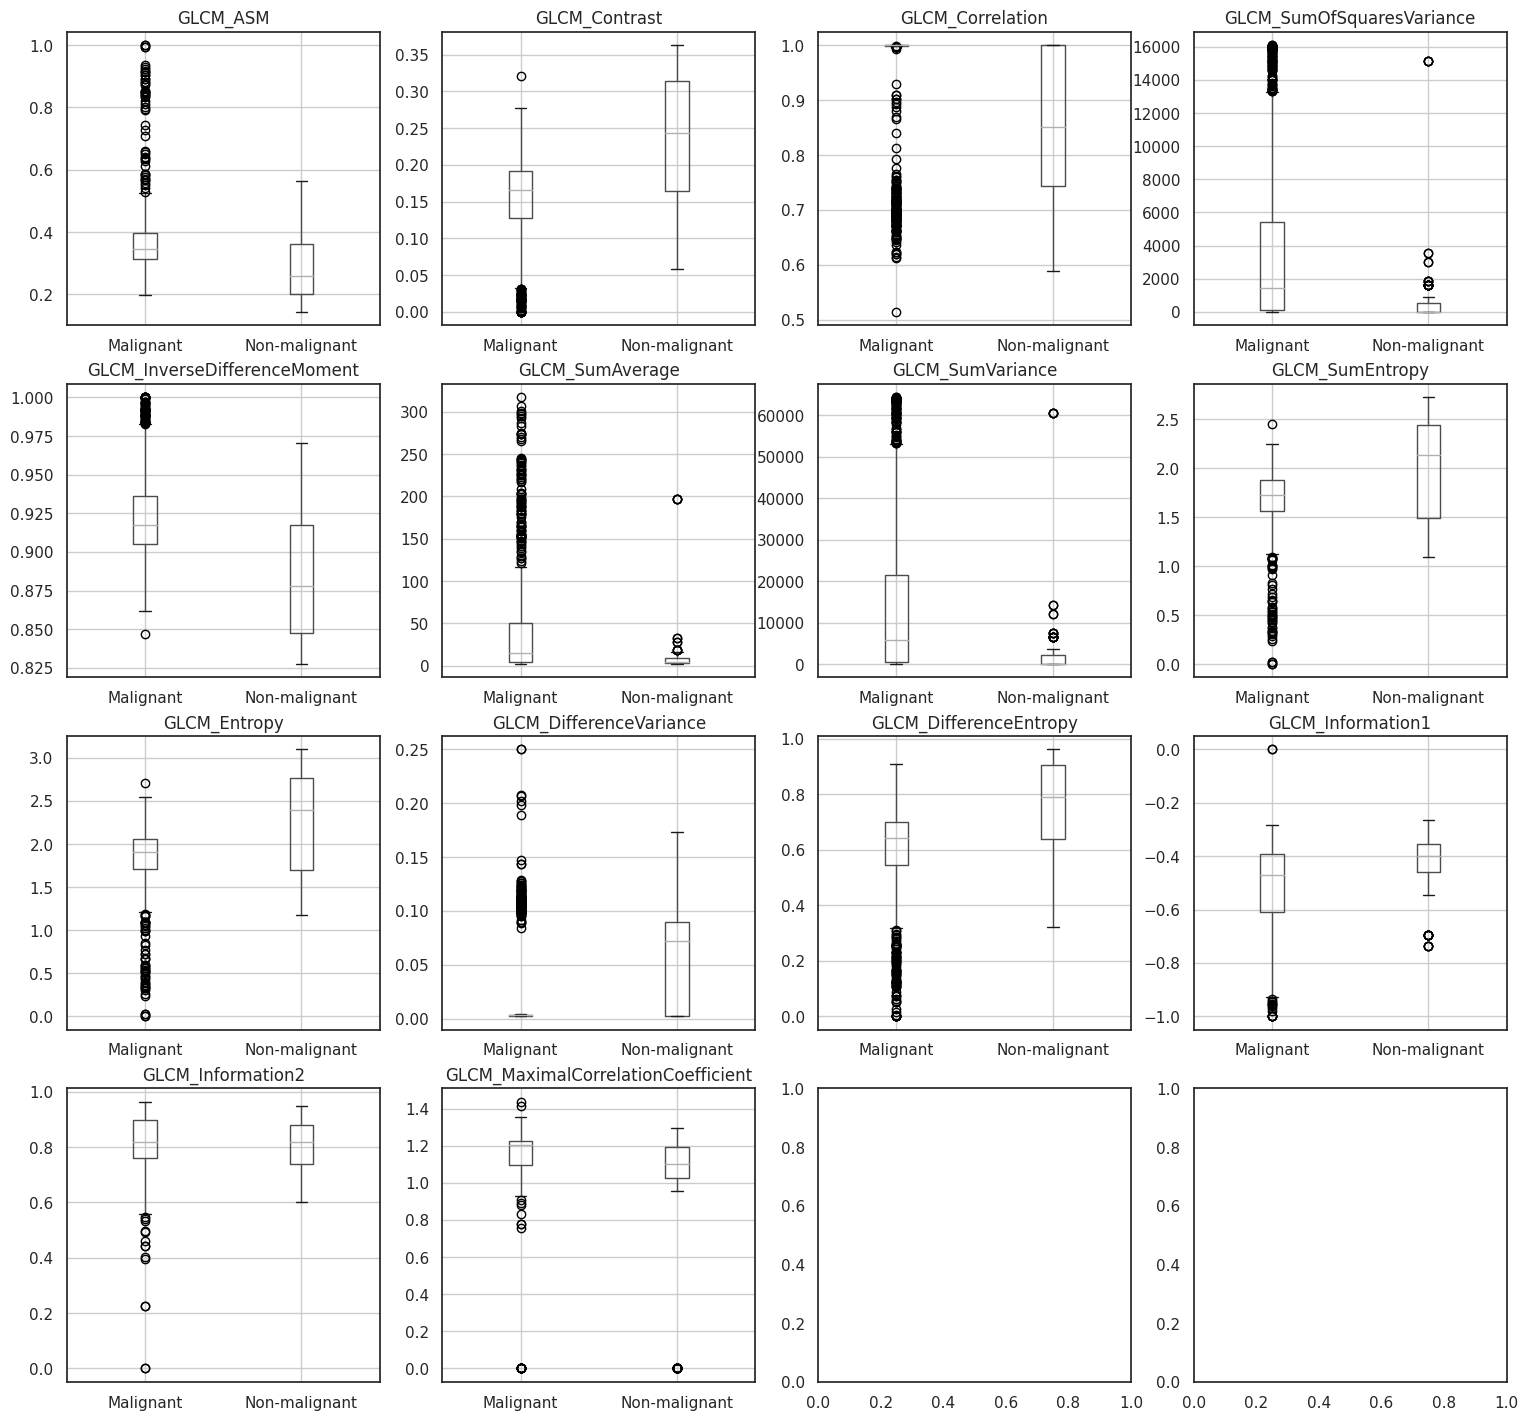

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(18, 18))
val.boxplot('GLCM_ASM','label', ax=ax[0, 0])
val.boxplot('GLCM_Contrast','label', ax=ax[0, 1])
val.boxplot('GLCM_Correlation','label', ax=ax[0,2])
val.boxplot('GLCM_SumOfSquaresVariance','label', ax=ax[0,3])
val.boxplot('GLCM_InverseDifferenceMoment','label', ax=ax[1,0])
val.boxplot('GLCM_SumAverage','label', ax=ax[1, 1])
val.boxplot('GLCM_SumVariance','label', ax=ax[1, 2])
val.boxplot('GLCM_SumEntropy','label', ax=ax[1,3])
val.boxplot('GLCM_Entropy','label', ax=ax[2,0])
val.boxplot('GLCM_DifferenceVariance','label', ax=ax[2,1])
val.boxplot('GLCM_DifferenceEntropy','label', ax=ax[2, 2])
val.boxplot('GLCM_Information1','label', ax=ax[2, 3])
val.boxplot('GLCM_Information2','label', ax=ax[3,0])
val.boxplot('GLCM_MaximalCorrelationCoefficient','label', ax=ax[3,1])

for ax in fig.axes:
  ax.set(xlabel=None)
fig.suptitle('')
plt.show()

<Axes: >

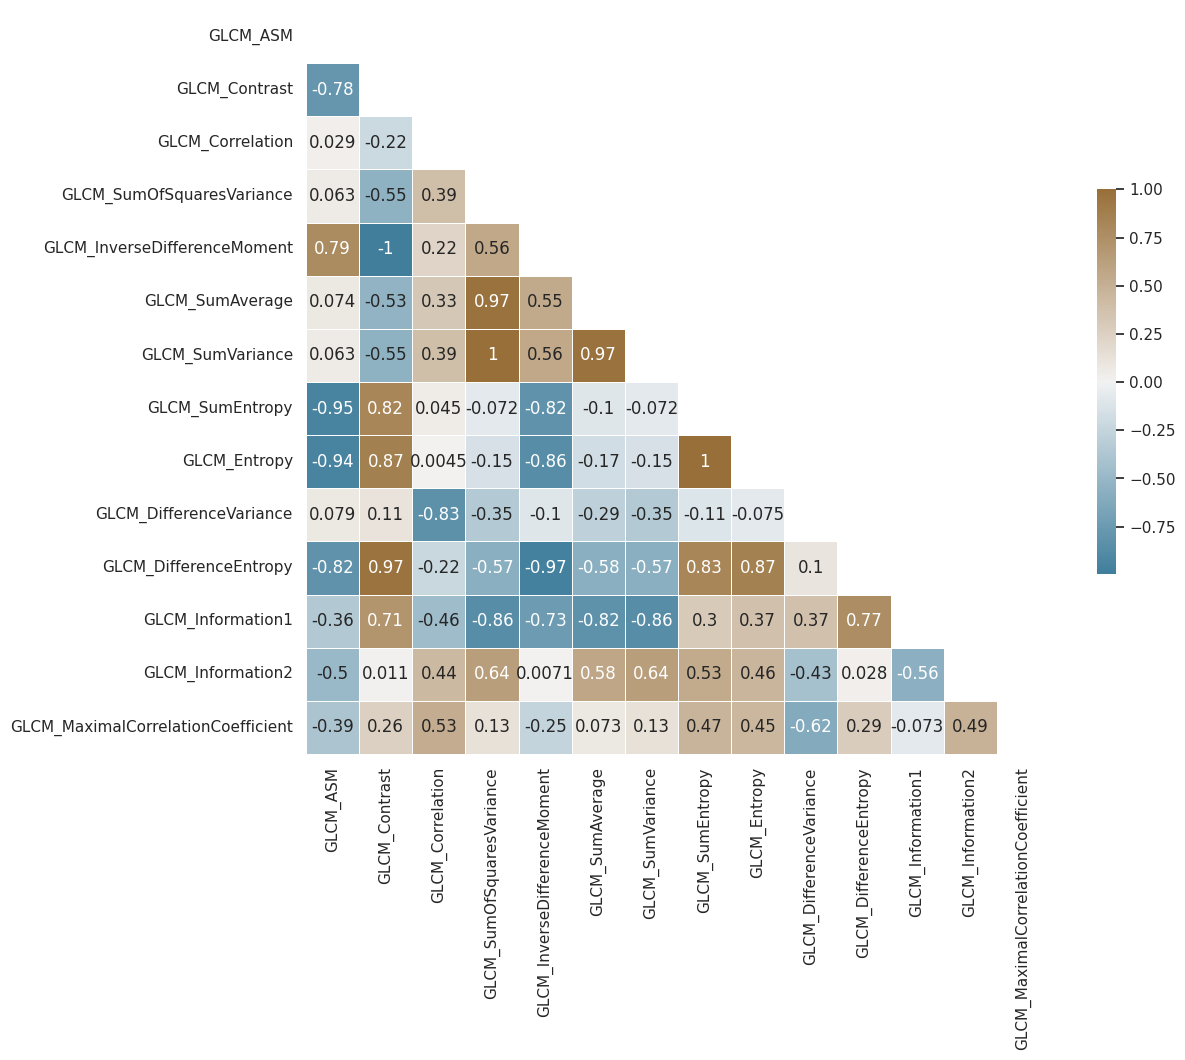

In [ ]:
master_table_val_drop = val.drop(['filepath', 'label', 'height', 'width', 'Empty',"Mean Pixel Value","Std Dev Pixel Value","Min Pixel Value","Max Pixel Value",
       "25th Percentile","50th Percentile (Median)","75th Percentile"],axis=1)
sns.set(style="white")
corr = master_table_val_drop.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 50, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

###**PCA**

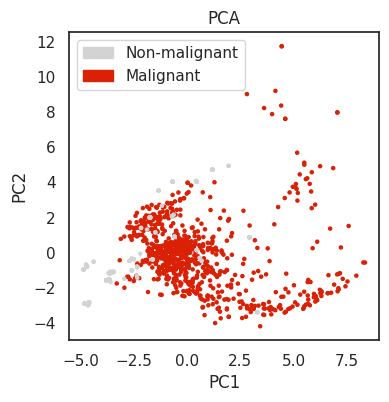

In [ ]:
colors = {'Non-malignant':'#D3D3D3', 'Malignant':'#DA2005'}
PCA_obj=PCA(n_components=2)

df=temp2
df=df.apply(zscore)
#print(df.head())

PCA_obj.fit(df)
x=PCA_obj.transform(df)[:,0]
y=PCA_obj.transform(df)[:,1]
plt.figure(figsize=[4,4])
plot = plt.scatter(x,y,c=val["label"].map(colors),s=5)
plt.title("PCA")
plt.xlabel('PC1')
plt.ylabel('PC2')

#define the legend
red_patch = mpatches.Patch(color='#DA2005', label='Malignant')
grey_patch = mpatches.Patch(color='#D3D3D3', label='Non-malignant')

plt.legend(handles=[grey_patch, red_patch])

#plt.savefig('PCA.jpg')
#files.download('PCA.jpg')

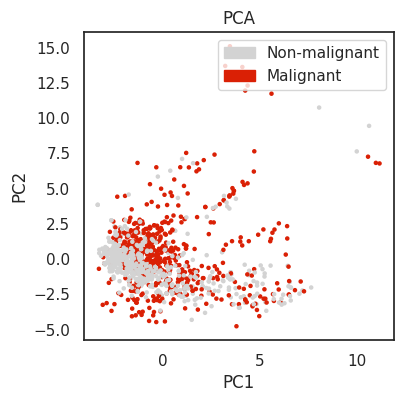

In [ ]:
colors = {'Non-malignant':'#D3D3D3', 'Malignant':'#DA2005'}
PCA_obj=PCA(n_components=2)

df=temp
df=df.apply(zscore)
#print(df.head())

PCA_obj.fit(df)
x=PCA_obj.transform(df)[:,0]
y=PCA_obj.transform(df)[:,1]
plt.figure(figsize=[4,4])
plot = plt.scatter(x,y,c=Lung_df_filtered_2["labels_2"].map(colors),s=5)
plt.title("PCA")
plt.xlabel('PC1')
plt.ylabel('PC2')

#define the legend
red_patch = mpatches.Patch(color='#DA2005', label='Malignant')
grey_patch = mpatches.Patch(color='#D3D3D3', label='Non-malignant')

plt.legend(handles=[grey_patch, red_patch])

#plt.savefig('PCA.jpg')
#files.download('PCA.jpg')

#**UNET Segmentation**#

##**Test Set**

###**Data/ Image Preprocessing**

In [ ]:
mapping={"Normal":"Non-malignant","Benign":"Non-malignant","Malignant":"Malignant"}
colors = {'Non-malignant':'#D3D3D3', 'Malignant':'#DA2005'}


In [ ]:
benign_dir_UNET = ['./data/The IQ-OTHNCCD lung cancer dataset/Bengin UNET Segmented']
Malignant_dir_UNET = ['./data/The IQ-OTHNCCD lung cancer dataset/Malignant UNET Segmented']
Normal_dir_UNET = ['./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented']

In [ ]:
#This code chunk takes ~5 mins
Lung_df_UNET = extract_metadata(benign_dir_UNET, Malignant_dir_UNET, Normal_dir_UNET)
Lung_df_UNET.head()

,filepaths,labels,info,jfif_version,jfif_unit,jfif_density,width,height
0,./data/The IQ-OTHNCCD lung cancer dataset/Bengin UNET Segmented/Bengin case (96).jpg,Benign,257,"(1, 1)",0,"(1, 1)",512,512
1,./data/The IQ-OTHNCCD lung cancer dataset/Bengin UNET Segmented/Bengin case (97).jpg,Benign,257,"(1, 1)",0,"(1, 1)",512,512
2,./data/The IQ-OTHNCCD lung cancer dataset/Bengin UNET Segmented/Bengin case (87).jpg,Benign,257,"(1, 1)",0,"(1, 1)",512,512
3,./data/The IQ-OTHNCCD lung cancer dataset/Bengin UNET Segmented/Bengin case (79).jpg,Benign,257,"(1, 1)",0,"(1, 1)",512,512
4,./data/The IQ-OTHNCCD lung cancer dataset/Bengin UNET Segmented/Bengin case (99).jpg,Benign,257,"(1, 1)",0,"(1, 1)",512,512


In [ ]:
Lung_df_UNET_filtered = Lung_df_UNET[Lung_df_UNET["width"]==512]
Lung_df_UNET_filtered = Lung_df_UNET_filtered[Lung_df_UNET_filtered["height"]==512]
print(f"# scans passed QC: {Lung_df_UNET_filtered.shape[0]}")

# scans passed QC: 1102


In [ ]:
Lung_df_UNET_filtered["labels_2"]= Lung_df_UNET_filtered["labels"].map(mapping)

In [ ]:
%%capture
#process images and add to image_array
#this chunk take ~7min
image_array_UNET=[]
for i in Lung_df_UNET_filtered["filepaths"]:
  img = cv.imread(i,cv.IMREAD_GRAYSCALE)
  img = np.where(img == 0, np.nan, img)
  #zscore the dataset, ignoring mask regions
  img[img != 0] = (img[img != np.nan]-np.nanmean(img[img != np.nan]))/np.nanstd(img[img != np.nan])
  image_array_UNET.append(img)

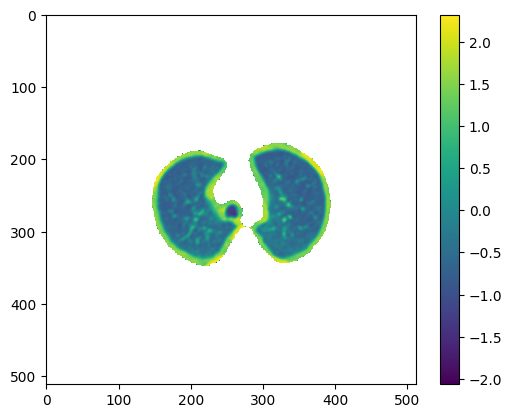

In [ ]:
plt.imshow(image_array_UNET[0])
plt.colorbar(plt.imshow(image_array_UNET[0]))


In [ ]:
image_stats_UNET = [compute_image_stats(image_path) for image_path in image_array_UNET]
image_stats_UNET_df = pd.DataFrame(image_stats_UNET)

In [ ]:
Lung_df_UNET_filtered_2 = pd.concat([Lung_df_UNET_filtered.reset_index(drop=True), image_stats_UNET_df.reset_index(drop=True)],axis=1)
print(len(Lung_df_UNET_filtered_2))
Lung_df_UNET_filtered_2.tail()

1102


,filepaths,labels,info,jfif_version,jfif_unit,jfif_density,width,height,labels_2,Mean Pixel Value,Std Dev Pixel Value,Min Pixel Value,Max Pixel Value,25th Percentile,50th Percentile (Median),75th Percentile
1097,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (100) (1).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-2.870199e-17,1.0,-1.649886,2.054901,-0.836640,-0.445077,1.211535
1098,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (100).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-2.870199e-17,1.0,-1.649886,2.054901,-0.836640,-0.445077,1.211535
1099,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (105).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,2.563164e-17,1.0,-1.628504,2.126206,-0.780667,-0.614127,1.232948
1100,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (109).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-9.330902e-17,1.0,-1.623906,2.044455,-0.787520,-0.655459,1.193395
1101,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (106).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-9.775061e-17,1.0,-1.669812,2.079169,-0.816385,-0.496350,1.225742


###**Extract Features**

In [ ]:
%%capture
#compute feature arrays for GLCM texture analysis
data_UNET=[]
for img in image_array_UNET:
    glcm = pyfeats.glcm_features(img,ignore_zeros=True)[0]
    data_UNET.append(glcm)

labels = ["GLCM_ASM", "GLCM_Contrast", "GLCM_Correlation","GLCM_SumOfSquaresVariance", "GLCM_InverseDifferenceMoment","GLCM_SumAverage", "GLCM_SumVariance", "GLCM_SumEntropy","GLCM_Entropy", "GLCM_DifferenceVariance","GLCM_DifferenceEntropy", "GLCM_Information1","GLCM_Information2", "GLCM_MaximalCorrelationCoefficient"]
temp_UNET = pd.DataFrame(data_UNET,columns=labels)
temp_UNET.head()

In [ ]:
#Concatenate feature attributes with metadata table
master_table_UNET = pd.concat([Lung_df_UNET_filtered_2.reset_index(drop=True), temp_UNET.reset_index(drop=True)], axis=1)
print(len(master_table_UNET))
master_table_UNET.tail()
#master_table.to_csv("normalized_metadata_w_features_2024_08_20.csv")
#from google.colab import files
#files.download("normalized_metadata_w_features_2024_08_20.csv")

1102


,filepaths,labels,info,jfif_version,jfif_unit,jfif_density,width,height,labels_2,Mean Pixel Value,...,GLCM_InverseDifferenceMoment,GLCM_SumAverage,GLCM_SumVariance,GLCM_SumEntropy,GLCM_Entropy,GLCM_DifferenceVariance,GLCM_DifferenceEntropy,GLCM_Information1,GLCM_Information2,GLCM_MaximalCorrelationCoefficient
1097,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (100) (1).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-2.870199e-17,...,0.999874,10.037706,4016.417123,0.121518,0.121769,0.003889,0.003344,-0.983459,0.456892,0.799779
1098,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (100).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-2.870199e-17,...,0.999874,10.037706,4016.417123,0.121518,0.121769,0.003889,0.003344,-0.983459,0.456892,0.799779
1099,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (105).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,2.563164e-17,...,0.999337,13.649079,5771.832761,0.176454,0.177719,0.003881,0.014319,-0.945751,0.520820,0.757379
1100,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (109).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-9.330902e-17,...,0.999844,15.642693,6735.461294,0.181354,0.181589,0.003889,0.003368,-0.987242,0.544979,0.750633
1101,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (106).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-9.775061e-17,...,0.999669,11.161648,4566.236333,0.141069,0.141731,0.003886,0.007926,-0.964283,0.479977,0.774222


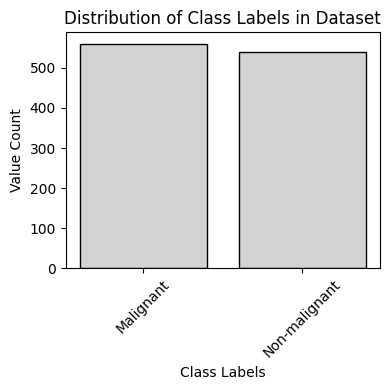

In [ ]:

label_counts = master_table_UNET['labels_2'].value_counts()


plt.figure(figsize=(4, 4))
plt.bar(label_counts.index, label_counts.values, color='#D3D3D3',edgecolor="black")
plt.xlabel('Class Labels')
plt.ylabel('Value Count')
plt.title('Distribution of Class Labels in Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

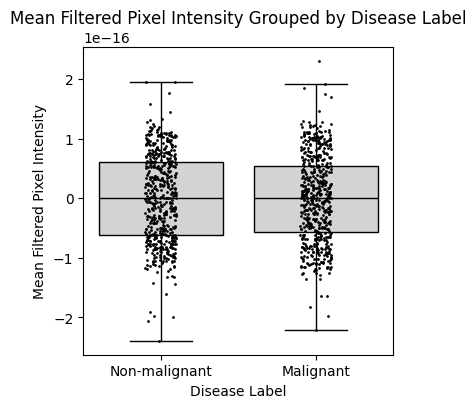

In [ ]:
plt.figure(figsize=(4, 4))
sns.boxplot(x=master_table_UNET["labels_2"],y=master_table_UNET['Mean Pixel Value'],showfliers=False,color="#D3D3D3",linecolor="black")
sns.stripplot(x=master_table_UNET["labels_2"],y=master_table_UNET['Mean Pixel Value'],color='black', size=2)
plt.title('Mean Filtered Pixel Intensity Grouped by Disease Label')
plt.ylabel('Mean Filtered Pixel Intensity')
plt.xlabel('Disease Label')
plt.show()

###**EDA**

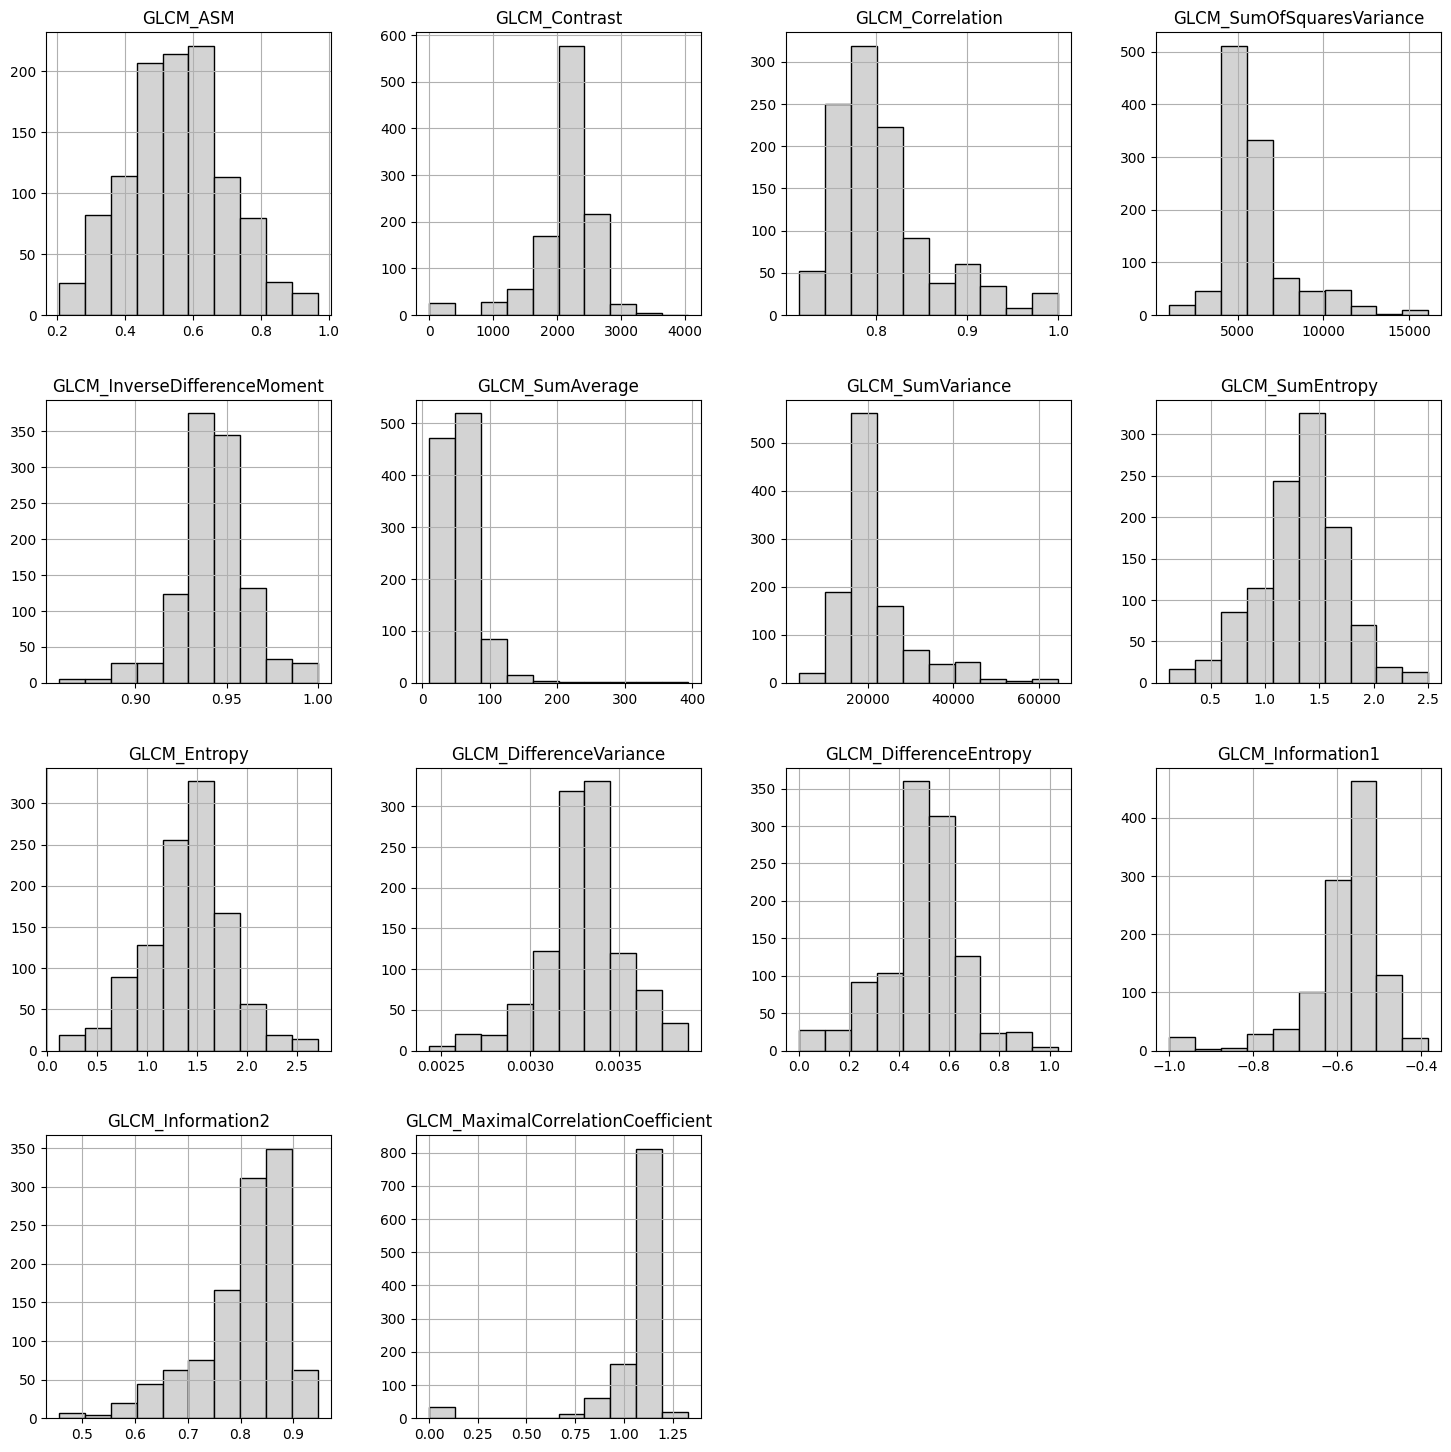

In [ ]:
master_table_UNET.drop(['filepaths', 'labels', 'info', 'jfif_version', 'jfif_unit',"Mean Pixel Value","Std Dev Pixel Value","Min Pixel Value","Max Pixel Value",
       'jfif_density','width', 'height',"25th Percentile","50th Percentile (Median)","75th Percentile"],axis=1).hist(bins=10, figsize=(18,18),edgecolor="black",color="#D3D3D3")
plt.show()

In [ ]:
master_table_UNET.drop(['filepaths', 'labels', 'info', 'jfif_version', 'jfif_unit',"Mean Pixel Value","Std Dev Pixel Value","Min Pixel Value","Max Pixel Value",
       'jfif_density','width', 'height',"25th Percentile","50th Percentile (Median)","75th Percentile"],axis=1).describe().T


,count,mean,std,min,25%,50%,75%,max
GLCM_ASM,1102.0,0.556702,0.144283,0.205620,0.467658,0.550375,0.646624,0.968214
GLCM_Contrast,1102.0,2142.136141,500.809280,0.000000,2021.465182,2229.738607,2403.802067,4046.051947
GLCM_Correlation,1102.0,0.807295,0.056143,0.714911,0.767927,0.793772,0.826073,1.000000
GLCM_SumOfSquaresVariance,1102.0,5967.050916,2113.864892,1004.104343,4730.480289,5493.654123,6430.752177,16122.422547
GLCM_InverseDifferenceMoment,1102.0,0.942783,0.019507,0.858159,0.933576,0.942865,0.952425,1.000000
GLCM_SumAverage,1102.0,57.277942,30.229038,10.037706,43.104080,50.304786,59.719788,393.343217
GLCM_SumVariance,1102.0,21726.067525,8447.160587,4016.417123,16671.607828,19620.580305,23343.172586,64488.189776
GLCM_SumEntropy,1102.0,1.326075,0.388433,0.121518,1.114789,1.367390,1.563024,2.499954
GLCM_Entropy,1102.0,1.407702,0.419271,0.121769,1.179675,1.446890,1.655746,2.707242
GLCM_DifferenceVariance,1102.0,0.003305,0.000229,0.002434,0.003198,0.003310,0.003416,0.003891


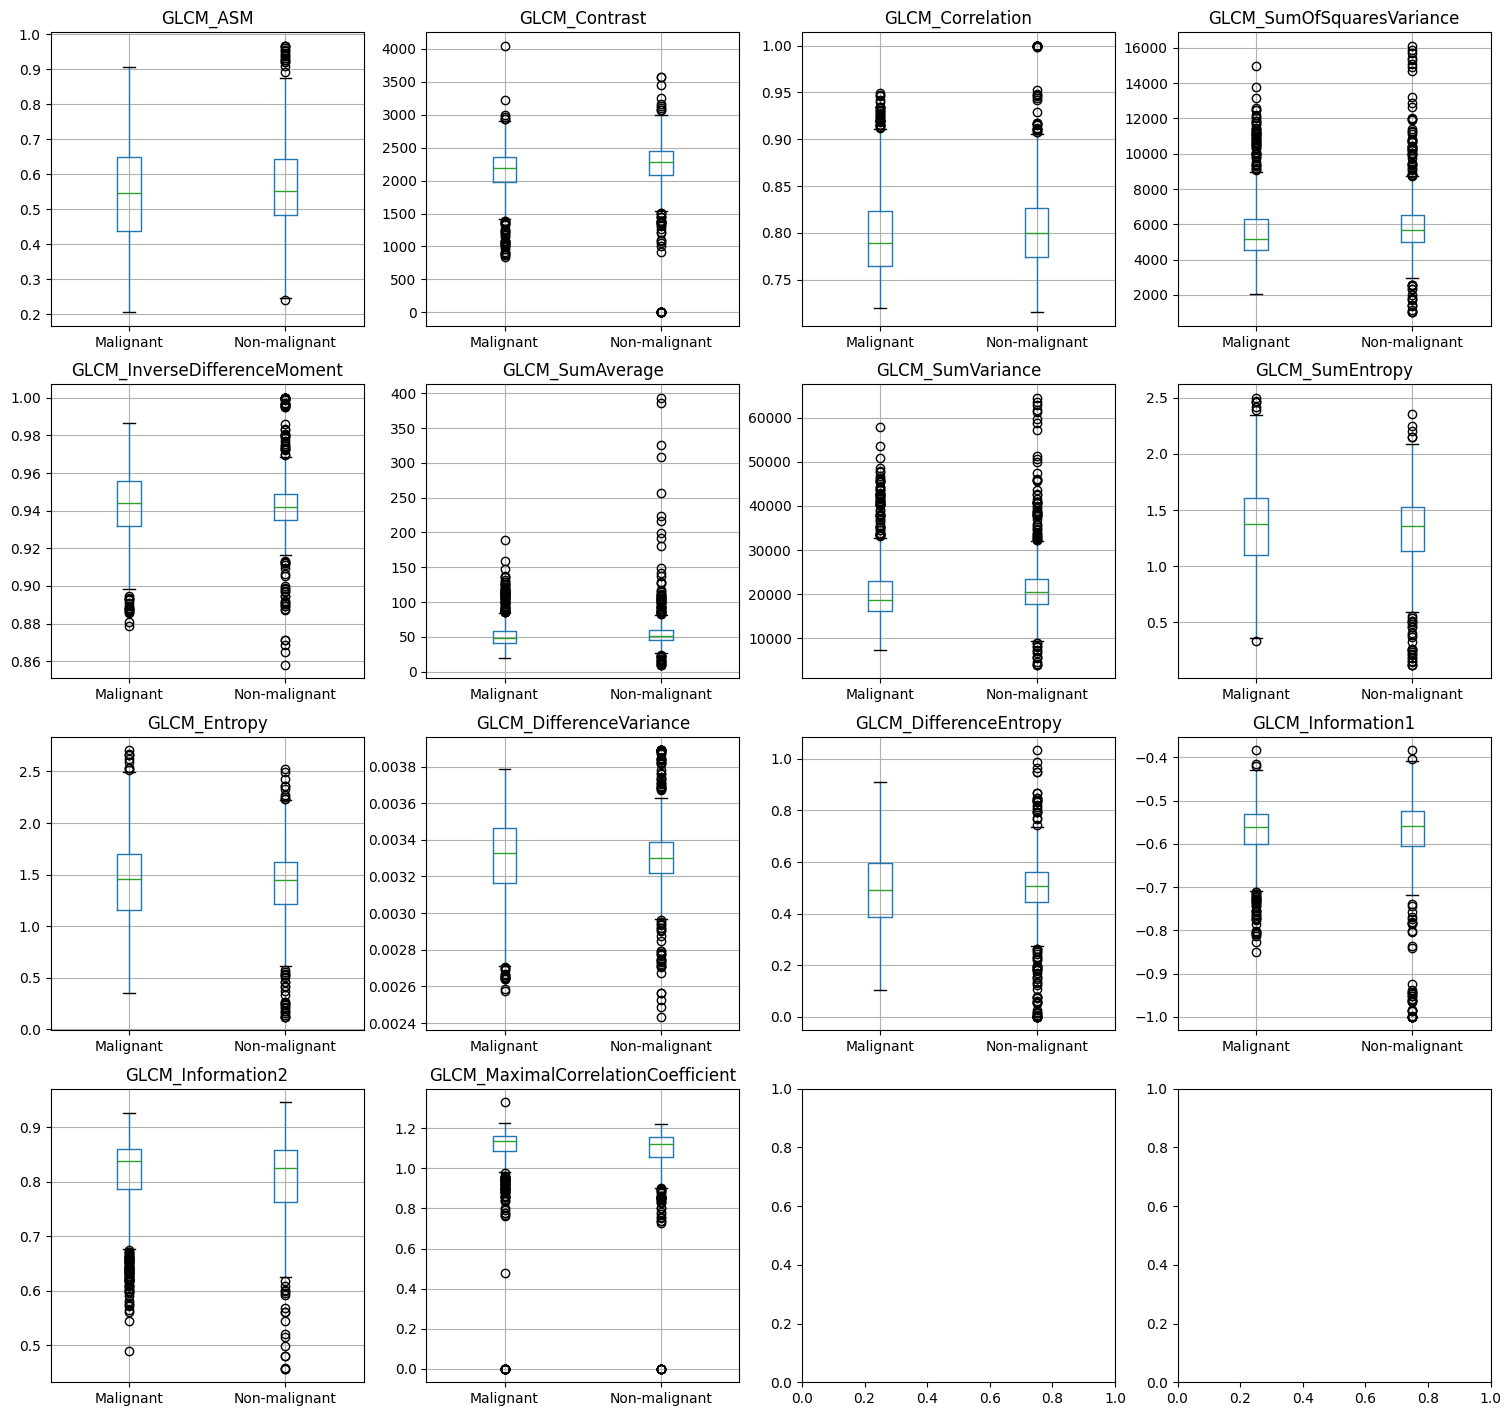

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(18, 18))
master_table_UNET.boxplot('GLCM_ASM','labels_2', ax=ax[0, 0])
master_table_UNET.boxplot('GLCM_Contrast','labels_2', ax=ax[0, 1])
master_table_UNET.boxplot('GLCM_Correlation','labels_2', ax=ax[0,2])
master_table_UNET.boxplot('GLCM_SumOfSquaresVariance','labels_2', ax=ax[0,3])
master_table_UNET.boxplot('GLCM_InverseDifferenceMoment','labels_2', ax=ax[1,0])
master_table_UNET.boxplot('GLCM_SumAverage','labels_2', ax=ax[1, 1])
master_table_UNET.boxplot('GLCM_SumVariance','labels_2', ax=ax[1, 2])
master_table_UNET.boxplot('GLCM_SumEntropy','labels_2', ax=ax[1,3])
master_table_UNET.boxplot('GLCM_Entropy','labels_2', ax=ax[2,0])
master_table_UNET.boxplot('GLCM_DifferenceVariance','labels_2', ax=ax[2,1])
master_table_UNET.boxplot('GLCM_DifferenceEntropy','labels_2', ax=ax[2, 2])
master_table_UNET.boxplot('GLCM_Information1','labels_2', ax=ax[2, 3])
master_table_UNET.boxplot('GLCM_Information2','labels_2', ax=ax[3,0])
master_table_UNET.boxplot('GLCM_MaximalCorrelationCoefficient','labels_2', ax=ax[3,1])

for ax in fig.axes:
  ax.set(xlabel=None)
fig.suptitle('')
plt.show()

<Axes: >

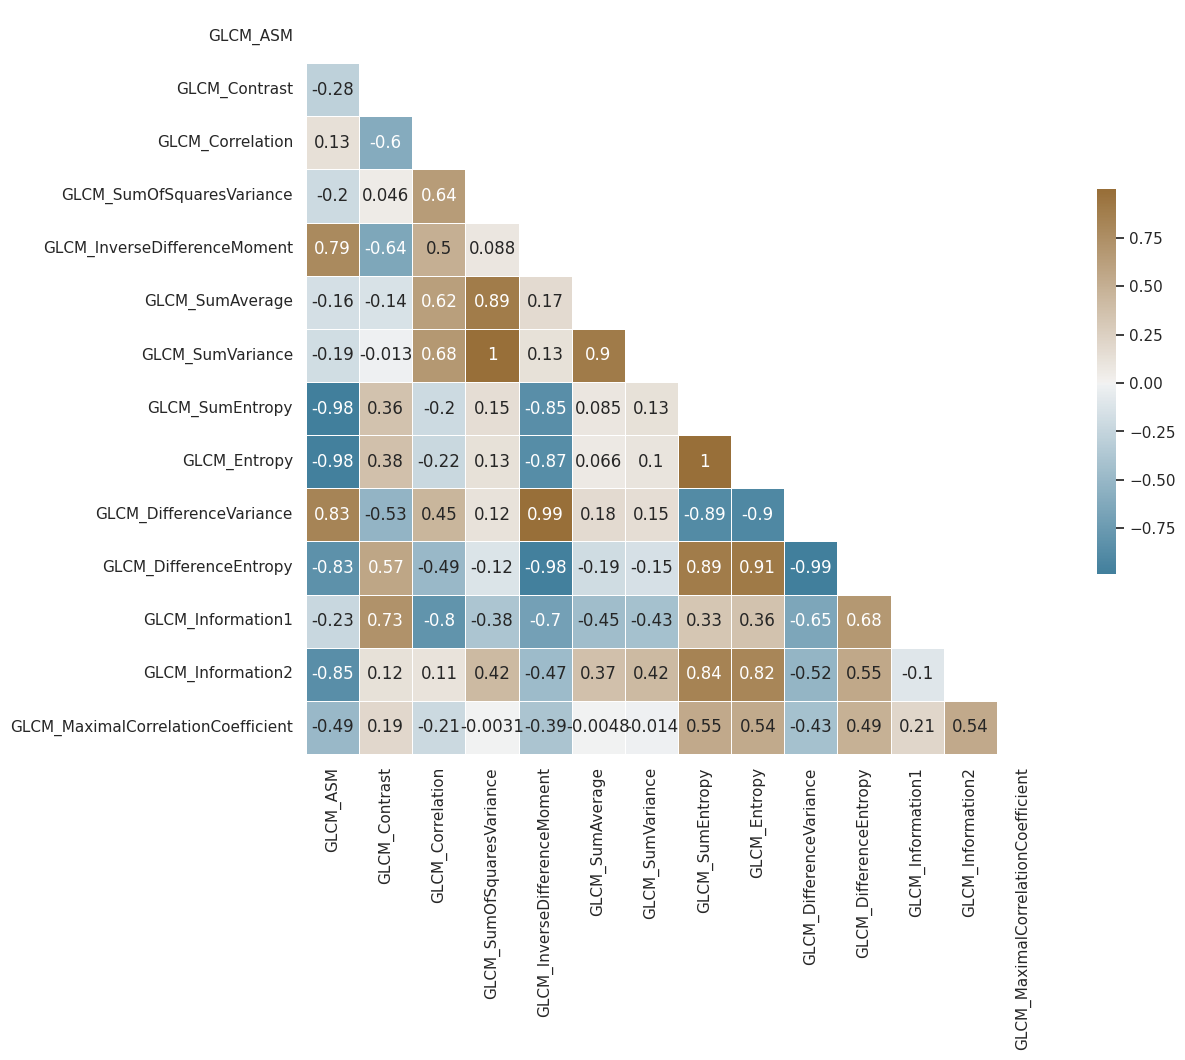

In [ ]:
master_table_UNET_drop = master_table_UNET.drop(columns=["Mean Pixel Value","Std Dev Pixel Value","25th Percentile","50th Percentile (Median)","75th Percentile",'filepaths', 'labels',"labels_2", 'info', 'jfif_version',
                                                               'jfif_unit', 'jfif_density', 'width', 'height','Max Pixel Value', 'Min Pixel Value'])
sns.set(style="white")
corr = master_table_UNET_drop.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 50, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

###**PCA**

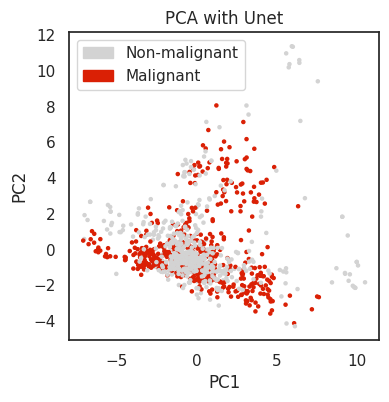

In [ ]:
colors = {'Non-malignant':'#D3D3D3', 'Malignant':'#DA2005'}
PCA_obj=PCA(n_components=2)

df=temp_UNET
df=df.apply(zscore)
#print(df.head())

PCA_obj.fit(df)
x=PCA_obj.transform(df)[:,0]
y=PCA_obj.transform(df)[:,1]
plt.figure(figsize=[4,4])
plot = plt.scatter(x,y,c=master_table_UNET["labels_2"].map(colors),s=5)
plt.title("PCA with Unet")
plt.xlabel('PC1')
plt.ylabel('PC2')

#define the legend
red_patch = mpatches.Patch(color='#DA2005', label='Malignant')
grey_patch = mpatches.Patch(color='#D3D3D3', label='Non-malignant')

plt.legend(handles=[grey_patch, red_patch])

#plt.savefig('PCA.jpg')
#files.download('PCA.jpg')

##**Validation Set**

###**Data/ Image Preprocessing**

In [ ]:
#Set Directories
normal_dir = ['./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented']
Malignant_dir = ['./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma UNET Segmented']
Malignant_dir2 = ['./data/DLCTLungDetectNet/Unrefined Data/squamous.cell.carcinoma UNET Segmented']
Malignant_dir3 = ['./data/DLCTLungDetectNet/Unrefined Data/adenocarcinoma UNET Segmented']

In [ ]:
#Extract metadata from validation dataset
dir_lists = [Malignant_dir,Malignant_dir2,Malignant_dir3, normal_dir]
filepaths=[]
labels=[]
class_labels = ["Malignant","Malignant",'Malignant','Normal']
for i, dir_list in enumerate(dir_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

height=[]
width=[]
for i in filepaths:
        tmp = Image.open(i)
        width.append(tmp.width)
        height.append(tmp.height)

Lung_df_UNET_validation = pd.DataFrame({'filepath': filepaths, 'label': labels,"height":height,"width":width})
Lung_df_UNET_validation.head()

,filepath,label,height,width
0,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma UNET Segmented/large.cell.carcinoma160.png,Malignant,512,512
1,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma UNET Segmented/large.cell.carcinoma131.png,Malignant,512,512
2,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma UNET Segmented/large.cell.carcinoma53.png,Malignant,512,512
3,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma UNET Segmented/large.cell.carcinoma24.png,Malignant,512,512
4,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma UNET Segmented/large.cell.carcinoma5.png,Malignant,512,512


In [ ]:
%%capture
#process images and add to image_array
#this chunk take ~7min
image_array_UNET_validation=[]
for i in Lung_df_UNET_validation["filepath"]:
  a = cv.imread(i)
  a = np.where(a == 0, np.nan, a)
  #zscore the dataset, ignoring mask regions
  a[a != np.nan] = (a[a != np.nan]-np.nanmean(a[a != np.nan]))/np.nanstd(a[a != np.nan])
  image_array_UNET_validation.append(a)


In [ ]:
empty=[]
for i in image_array_UNET_validation:
  if np.isnan(i).all():
    empty.append("Empty")
  else:
    empty.append("Not Empty")

Lung_df_UNET_validation["Empty"] = empty
pd.value_counts(Lung_df_UNET_validation["Empty"])

<ipython-input-27-86eaff9116f6>:9: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(Lung_df_UNET_validation["Empty"])


,count
Empty,
Not Empty,977
Empty,23


In [ ]:
image_array_UNET_clean = [img for img, is_empty in zip(image_array_UNET_validation, Lung_df_UNET_validation["Empty"]=="Not Empty") if is_empty]
Lung_df_UNET_filtered_validation = Lung_df_UNET_validation[Lung_df_UNET_validation["Empty"]=="Not Empty"]

In [ ]:
image_stats_UNET_validation = [compute_image_stats(image_path) for image_path in image_array_UNET_clean]
image_stats_UNET_df_validation = pd.DataFrame(image_stats_UNET_validation)

In [ ]:
Lung_df_UNET_filtered_2_validation = pd.concat([Lung_df_UNET_filtered_validation.reset_index(drop=True), image_stats_UNET_df_validation.reset_index(drop=True)],axis=1)
print(len(Lung_df_UNET_filtered_2_validation))
Lung_df_UNET_filtered_2_validation.tail()

977


,filepath,label,height,width,Empty,Mean Pixel Value,Std Dev Pixel Value,Min Pixel Value,Max Pixel Value,25th Percentile,50th Percentile (Median),75th Percentile
972,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal80.png,Normal,512,512,Not Empty,1.427013e-16,1.0,-4.724889,1.831278,-0.630742,-0.105142,0.669426
973,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal82.png,Normal,512,512,Not Empty,1.427013e-16,1.0,-4.724889,1.831278,-0.630742,-0.105142,0.669426
974,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal90.png,Normal,512,512,Not Empty,1.446303e-16,1.0,-0.706634,4.048095,-0.483407,-0.394117,-0.215535
975,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal84.png,Normal,512,512,Not Empty,1.427013e-16,1.0,-4.724889,1.831278,-0.630742,-0.105142,0.669426
976,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal96.png,Normal,512,512,Not Empty,-3.558535e-17,1.0,-0.705584,4.064948,-0.481615,-0.392028,-0.212853


###**Extract Features**

In [ ]:
%%capture
#compute feature arrays for GLCM texture analysis
data2_UNET=[]
for img in image_array_UNET_clean:
    glcm = pyfeats.glcm_features(img,ignore_zeros=True)[0]
    data2_UNET.append(glcm)

labels = ["GLCM_ASM", "GLCM_Contrast", "GLCM_Correlation","GLCM_SumOfSquaresVariance", "GLCM_InverseDifferenceMoment","GLCM_SumAverage", "GLCM_SumVariance", "GLCM_SumEntropy","GLCM_Entropy", "GLCM_DifferenceVariance","GLCM_DifferenceEntropy", "GLCM_Information1","GLCM_Information2", "GLCM_MaximalCorrelationCoefficient"]
temp2_UNET = pd.DataFrame(data2_UNET,columns=labels)
temp2_UNET.head()

In [ ]:
#Concatenate feature attributes with metadata table
master_table_UNET_validation = pd.concat([Lung_df_UNET_filtered_2_validation.reset_index(drop=True), temp2_UNET.reset_index(drop=True)], axis=1)
print(len(master_table_UNET_validation))
master_table_UNET_validation.tail()
#Lung_df.to_csv("validation_normalized_metadata_w_features_2024_08_20.csv")
#from google.colab import files
#files.download("validation_normalized_metadata_w_features_2024_08_20.csv")

977


,filepath,label,height,width,Empty,Mean Pixel Value,Std Dev Pixel Value,Min Pixel Value,Max Pixel Value,25th Percentile,...,GLCM_InverseDifferenceMoment,GLCM_SumAverage,GLCM_SumVariance,GLCM_SumEntropy,GLCM_Entropy,GLCM_DifferenceVariance,GLCM_DifferenceEntropy,GLCM_Information1,GLCM_Information2,GLCM_MaximalCorrelationCoefficient
972,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal80.png,Normal,512,512,Not Empty,1.427013e-16,1.0,-4.724889,1.831278,-0.630742,...,0.982483,133.939460,49413.165249,1.264765,1.303732,0.003634,0.217408,-0.897470,0.938013,1.355677
973,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal82.png,Normal,512,512,Not Empty,1.427013e-16,1.0,-4.724889,1.831278,-0.630742,...,0.982483,133.939460,49413.165249,1.264765,1.303732,0.003634,0.217408,-0.897470,0.938013,1.355677
974,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal90.png,Normal,512,512,Not Empty,1.446303e-16,1.0,-0.706634,4.048095,-0.483407,...,0.910168,3.877048,1.718826,2.018199,2.201798,0.103098,0.647958,-0.512619,0.869771,0.982923
975,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal84.png,Normal,512,512,Not Empty,1.427013e-16,1.0,-4.724889,1.831278,-0.630742,...,0.982483,133.939460,49413.165249,1.264765,1.303732,0.003634,0.217408,-0.897470,0.938013,1.355677
976,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal96.png,Normal,512,512,Not Empty,-3.558535e-17,1.0,-0.705584,4.064948,-0.481615,...,0.909405,3.907800,1.707487,2.017880,2.203591,0.102748,0.651353,-0.508859,0.867622,0.982645


In [ ]:
%%capture
val_UNET = master_table_UNET_validation
val_UNET["label"][val_UNET["label"]=="Malignant"]="Malignant"
val_UNET["label"][val_UNET["label"]=="Normal"]="Non-malignant"

###**EDA**

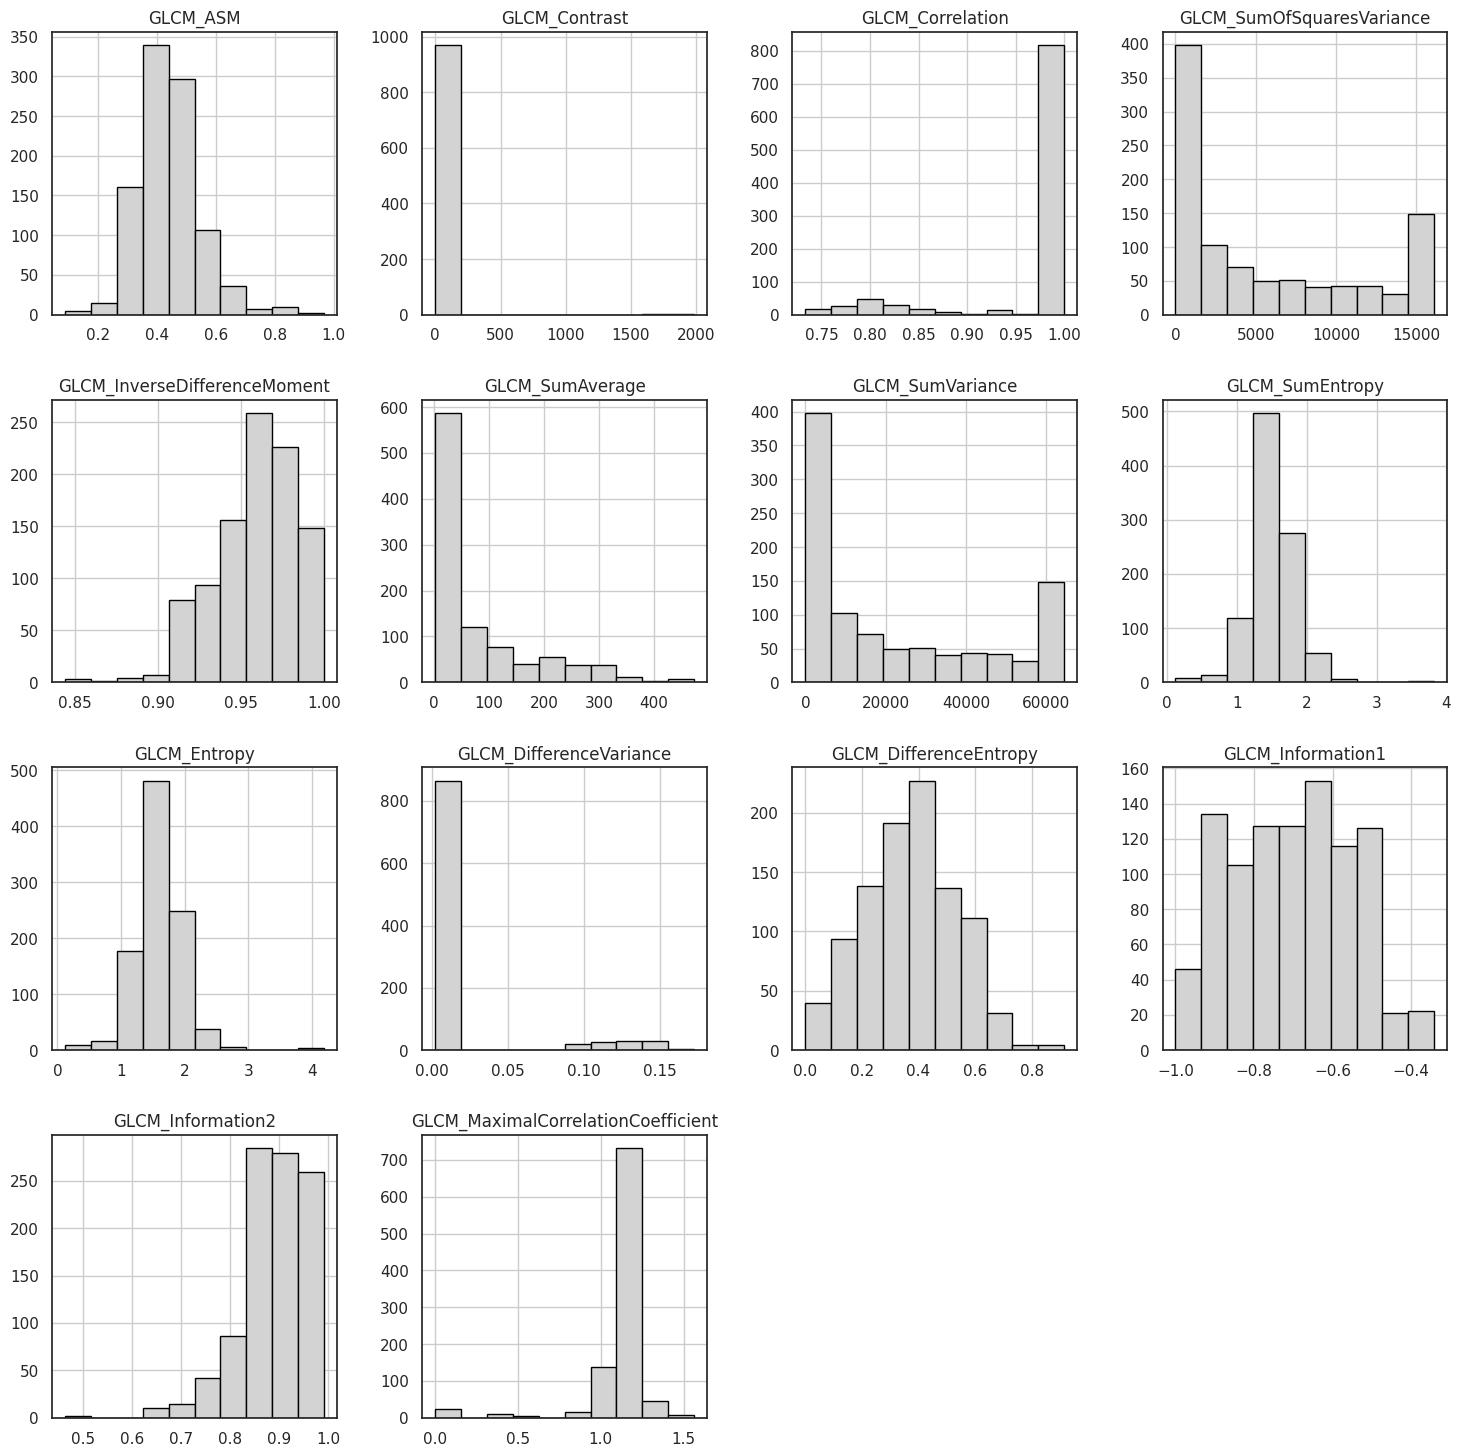

In [ ]:
val_UNET.drop(['filepath', 'label', 'height', 'width', 'Empty',"Mean Pixel Value","Std Dev Pixel Value","Min Pixel Value","Max Pixel Value",
       "25th Percentile","50th Percentile (Median)","75th Percentile"],axis=1).hist(bins=10, figsize=(18,18),edgecolor="black",color="#D3D3D3")
plt.show()

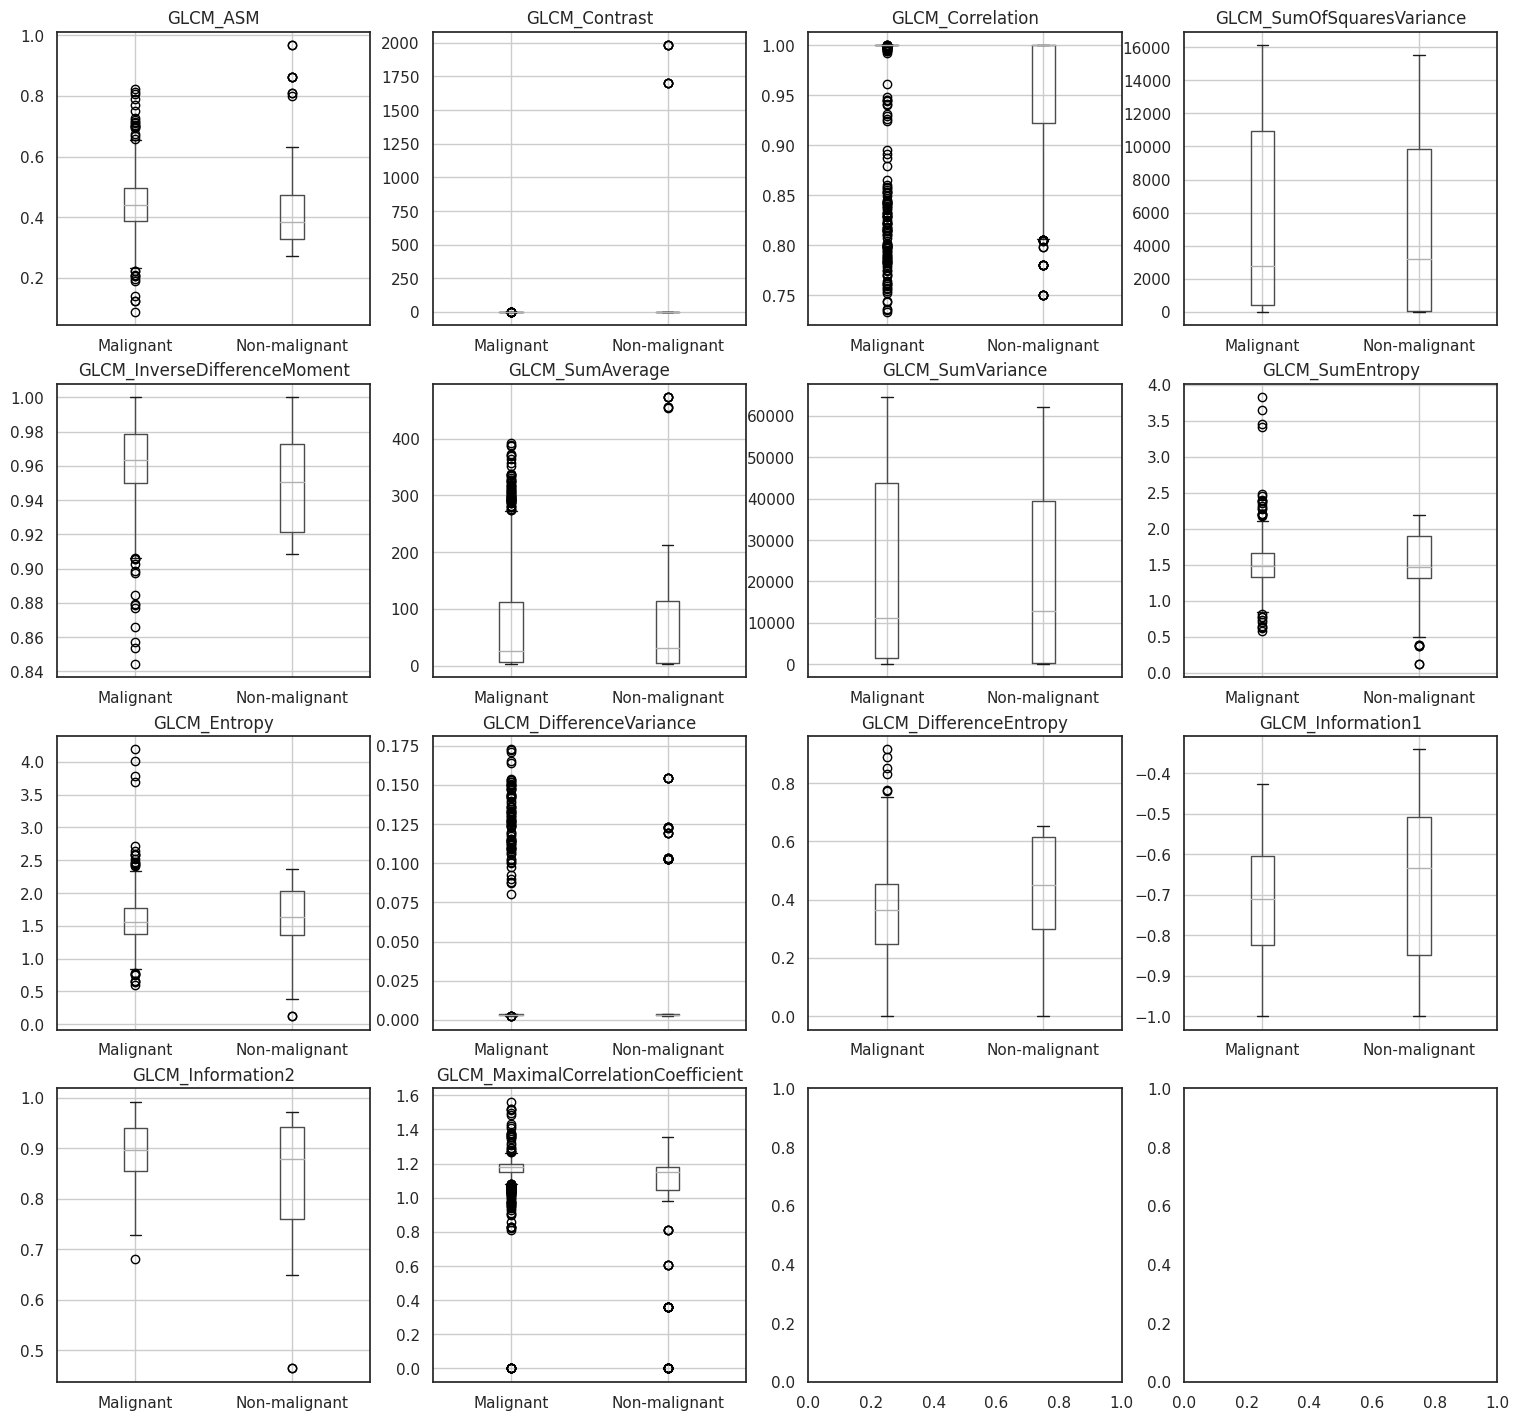

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(18, 18))
val_UNET.boxplot('GLCM_ASM','label', ax=ax[0, 0])
val_UNET.boxplot('GLCM_Contrast','label', ax=ax[0, 1])
val_UNET.boxplot('GLCM_Correlation','label', ax=ax[0,2])
val_UNET.boxplot('GLCM_SumOfSquaresVariance','label', ax=ax[0,3])
val_UNET.boxplot('GLCM_InverseDifferenceMoment','label', ax=ax[1,0])
val_UNET.boxplot('GLCM_SumAverage','label', ax=ax[1, 1])
val_UNET.boxplot('GLCM_SumVariance','label', ax=ax[1, 2])
val_UNET.boxplot('GLCM_SumEntropy','label', ax=ax[1,3])
val_UNET.boxplot('GLCM_Entropy','label', ax=ax[2,0])
val_UNET.boxplot('GLCM_DifferenceVariance','label', ax=ax[2,1])
val_UNET.boxplot('GLCM_DifferenceEntropy','label', ax=ax[2, 2])
val_UNET.boxplot('GLCM_Information1','label', ax=ax[2, 3])
val_UNET.boxplot('GLCM_Information2','label', ax=ax[3,0])
val_UNET.boxplot('GLCM_MaximalCorrelationCoefficient','label', ax=ax[3,1])

for ax in fig.axes:
  ax.set(xlabel=None)
fig.suptitle('')
plt.show()

<Axes: >

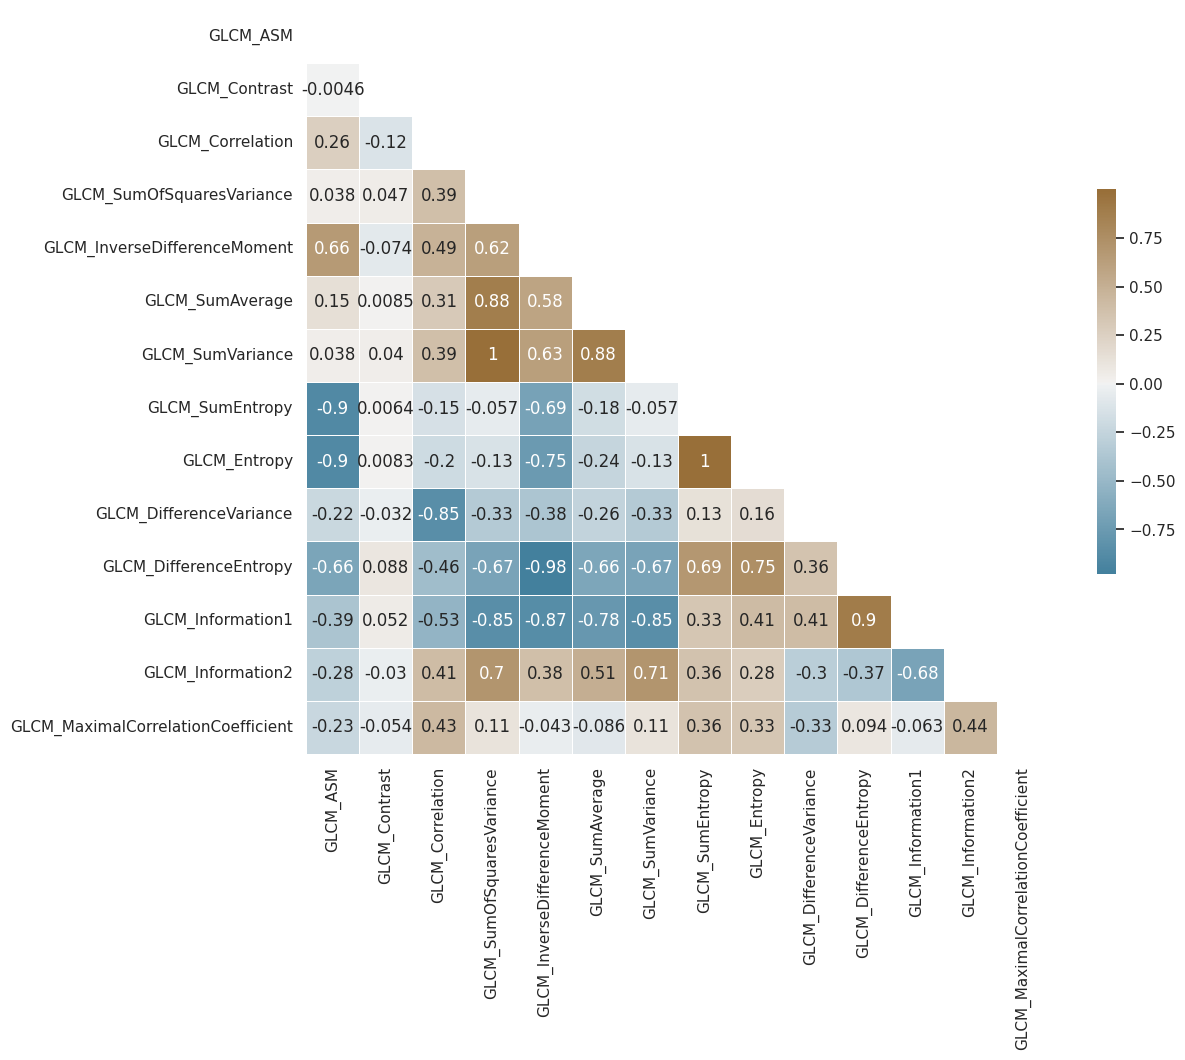

In [ ]:
master_table_UNET_val_drop = val_UNET.drop(['filepath', 'label', 'height', 'width', 'Empty',"Mean Pixel Value","Std Dev Pixel Value","Min Pixel Value","Max Pixel Value",
       "25th Percentile","50th Percentile (Median)","75th Percentile"],axis=1)
sns.set(style="white")
corr = master_table_UNET_val_drop.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 50, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

###**PCA**

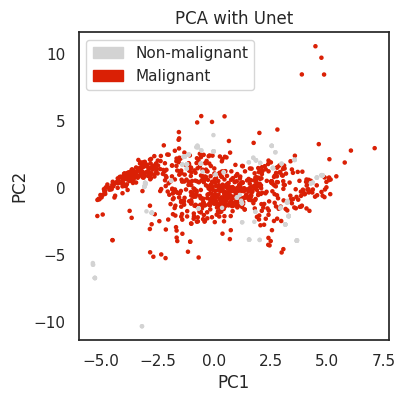

In [ ]:
colors = {'Non-malignant':'#D3D3D3', 'Malignant':'#DA2005'}
PCA_obj=PCA(n_components=2)

df=temp2_UNET
df=df.apply(zscore)
#print(df.head())

PCA_obj.fit(df)
x=PCA_obj.transform(df)[:,0]
y=PCA_obj.transform(df)[:,1]
plt.figure(figsize=[4,4])
plot = plt.scatter(x,y,c=val_UNET["label"].map(colors),s=5)
plt.title("PCA with Unet")
plt.xlabel('PC1')
plt.ylabel('PC2')

#define the legend
red_patch = mpatches.Patch(color='#DA2005', label='Malignant')
grey_patch = mpatches.Patch(color='#D3D3D3', label='Non-malignant')

plt.legend(handles=[grey_patch, red_patch])

#plt.savefig('PCA.jpg')
#files.download('PCA.jpg')